In [79]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
from tqdm import tqdm_notebook
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(plt, name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=300)

%load_ext version_information
%version_information pandas, numpy

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.15.4
Tue Mar 19 21:16:05 2019 PDT

## Bayesian Modeling Discussion

We can model the probability of an outcome $y$ as $P_t(y)$ using a discrete **Poisson distribution** i.e. if discretizing the time $t$ in seconds.

$$
P_t(\mu) = \frac{\mu^te^{-\mu}}{k!}
$$

Instead we could also assume a Gamma posterior, which has the advantage of being continuous and has more parameters than can be optimized. For now we'll stick with using the simpler Poisson distribution.

Based on a set of goalie pull observations $X$ from 2003-2007 NHL games, we'll solve for the posterior distribution $P_t(y|X)$, the probability of the outcome $y$, given the observations. This is done computationally using markov chain monte carlo and the `pymc3` library.

The outcomes we're interested in are $y = \big\{\mathrm{goal\;for}, \mathrm{goal\;against}, \mathrm{no\;goal}\big\}$. 

We'll use a **uniform prior** over the domain of times (last 5mins). Note: when gathering the observations, we throw out goalie pulls greater than 5 minutes from the end of the game (due to high likelihood of false positives when parsing goalie pulls from the raw game table).

Once we find the posteriors discussed above, we can study the risk reward of pulling a goalie. We'll compare posteriors to find the odds of scoring a goal (and the odds of getting scored on) over time $t$ where:
 - **t = Time elapsed** e.g. if there's 3 minutes left, what is the chance that pulling the goalie will result in a goal for?
 - **t = Time since goalie pull** e.g. after the goalie has been pulled for 1 minute, what is the chance of getting a goal?

In [80]:
import pymc3 as pm

### Load the training data

In [81]:
ls ../../data/processed/pkl/

20032004_goalie_pulls_2019-03-01.pkl  20062007_goalie_pulls_2019-03-01.pkl
20052006_goalie_pulls_2019-03-01.pkl


In [82]:
def load_data():
    files = glob.glob('../../data/processed/pkl/*.pkl')
    files = sorted(files)
    print(files)
    return pd.concat((pd.read_pickle(f) for f in files))

def clean_df(df):
    _df = df.copy()
    
    len_0 = _df.shape[0]
    print('Removing goal_for_time < 15 mins')
    _df = _df[~(_df.goal_for_time < datetime.timedelta(seconds=15*60))]
    print(f'Removed {len_0 - _df.shape[0]} total rows')
    
    if 'game_end_time' in df.columns:
        len_0 = _df.shape[0]
        print('Removing game_end_time < 15 mins')
        _df = _df[~(_df.game_end_time < datetime.timedelta(seconds=60*15))]
        print(f'Removed {len_0 - _df.shape[0]} total rows')

    return _df

In [83]:
df = load_data()
df = clean_df(df)

['../../data/processed/pkl/20032004_goalie_pulls_2019-03-01.pkl', '../../data/processed/pkl/20052006_goalie_pulls_2019-03-01.pkl', '../../data/processed/pkl/20062007_goalie_pulls_2019-03-01.pkl']
Removing goal_for_time < 15 mins
Removed 1 total rows


In [84]:
def load_training_samples(
    df,
    cols,
    masks=[],
    dtype='timedelta64[s]'
) -> np.ndarray:
    '''
    Return buckets of training data.
    '''
    if not masks:
        masks = [None] * len(cols)
    out = []
    for col, m in zip(cols, masks):
        if m is None:
            d = df[col].dropna().astype(dtype).values
        else:
            d = df[col][m].dropna().astype(dtype).values
        out.append(d)
        print(f'Loaded {len(d)} samples for col {col}')

    out = np.array(out)
    print(f'Training data shape = {out.shape}')
    return out

## Model 1 - Time elapsed

### Load data

In [85]:
# Load time of pull for eventual outcomes:
feature_names = ['goal_for', 'goal_against', 'no_goals']

# Logic for loading the data
features = ['pull_time', 'pull_time', 'pull_time']
masks = [
    ~(df.goal_for_time.isnull()),
    ~(df.goal_against_time.isnull()),
    ~(df.game_end_timedelta.isnull()),
]
training_samples = load_training_samples(df, features, masks)

Loaded 270 samples for col pull_time
Loaded 554 samples for col pull_time
Loaded 1305 samples for col pull_time
Training data shape = (3,)


In [86]:
(training_samples[0][:10],
training_samples[1][:10],
training_samples[2][:10],)

(array([1119., 1114., 1109., 1111., 1081., 1121., 1100., 1103., 1145.,
        1142.]),
 array([1184., 1143., 1168., 1133., 1133., 1140., 1118., 1130., 1148.,
        1104.]),
 array([1198., 1125., 1068., 1151., 1119., 1137., 1131., 1140., 1192.,
        1137.]))

In [87]:
feature_names

['goal_for', 'goal_against', 'no_goals']

### PyMC3 Model

In [88]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors for the mu parameter of the
        # Poisson distribution P.
        # Note: mu = mean(P)
        mu_goal_for = pm.Uniform(
            'mu_goal_for', 15*60, 20*60
        )
        mu_goal_against = pm.Uniform(
            'mu_goal_against', 15*60, 20*60
        )
        mu_no_goal = pm.Uniform(
            'mu_no_goal', 15*60, 20*60
        )
        
        # Observations to train the model on
        obs_goal_for = pm.Poisson(
            'obs_goal_for',
            mu=mu_goal_for,
            observed=training_samples[0],
        )
        obs_goal_against = pm.Poisson(
            'obs_goal_against',
            mu=mu_goal_against,
            observed=training_samples[1],
        )
        obs_no_goal = pm.Poisson(
            'obs_no_goal',
            mu=mu_no_goal,
            observed=training_samples[2],
        )
        
        # Outcome probabilities
        p_goal_for = pm.Bound(pm.Poisson, upper=20*60)('p_goal_for', mu=mu_goal_for)
        p_goal_against = pm.Bound(pm.Poisson, upper=20*60)('p_goal_against', mu=mu_goal_against)
        p_no_goal = pm.Bound(pm.Poisson, upper=20*60)('p_no_goal', mu=mu_no_goal)
        
        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_no_goal]
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_no_goal]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:29<00:00, 2512.99draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [89]:
N_burn = 10000
burned_trace = trace[N_burn:]

In [90]:
from typing import Tuple
from scipy.stats import poisson

def poisson_posterior(
    mu=None,
    norm_factors=None,
) -> Tuple[np.ndarray]:

    p = poisson.pmf
    x = np.arange(15*60, 20*60, 1)
    if mu is None:
        return (x / 60,)
    
    mu_goal_for = mu[0]
    mu_goal_against = mu[1]
    mu_no_goal = mu[2]

    y_goal_for = p(x, mu_goal_for)
    y_goal_against = p(x, mu_goal_against)
    y_no_goal = p(x, mu_no_goal)
    
    if norm_factors is not None:
        y_goal_for = p(x, mu_goal_for) * norm_factors[0]
        y_goal_against = p(x, mu_goal_against) * norm_factors[1]
        y_no_goal = p(x, mu_no_goal) * norm_factors[2]
    
    # Convert into minutes
    x = x / 60

    return x, y_goal_for, y_goal_against, y_no_goal


### MCMC Samples

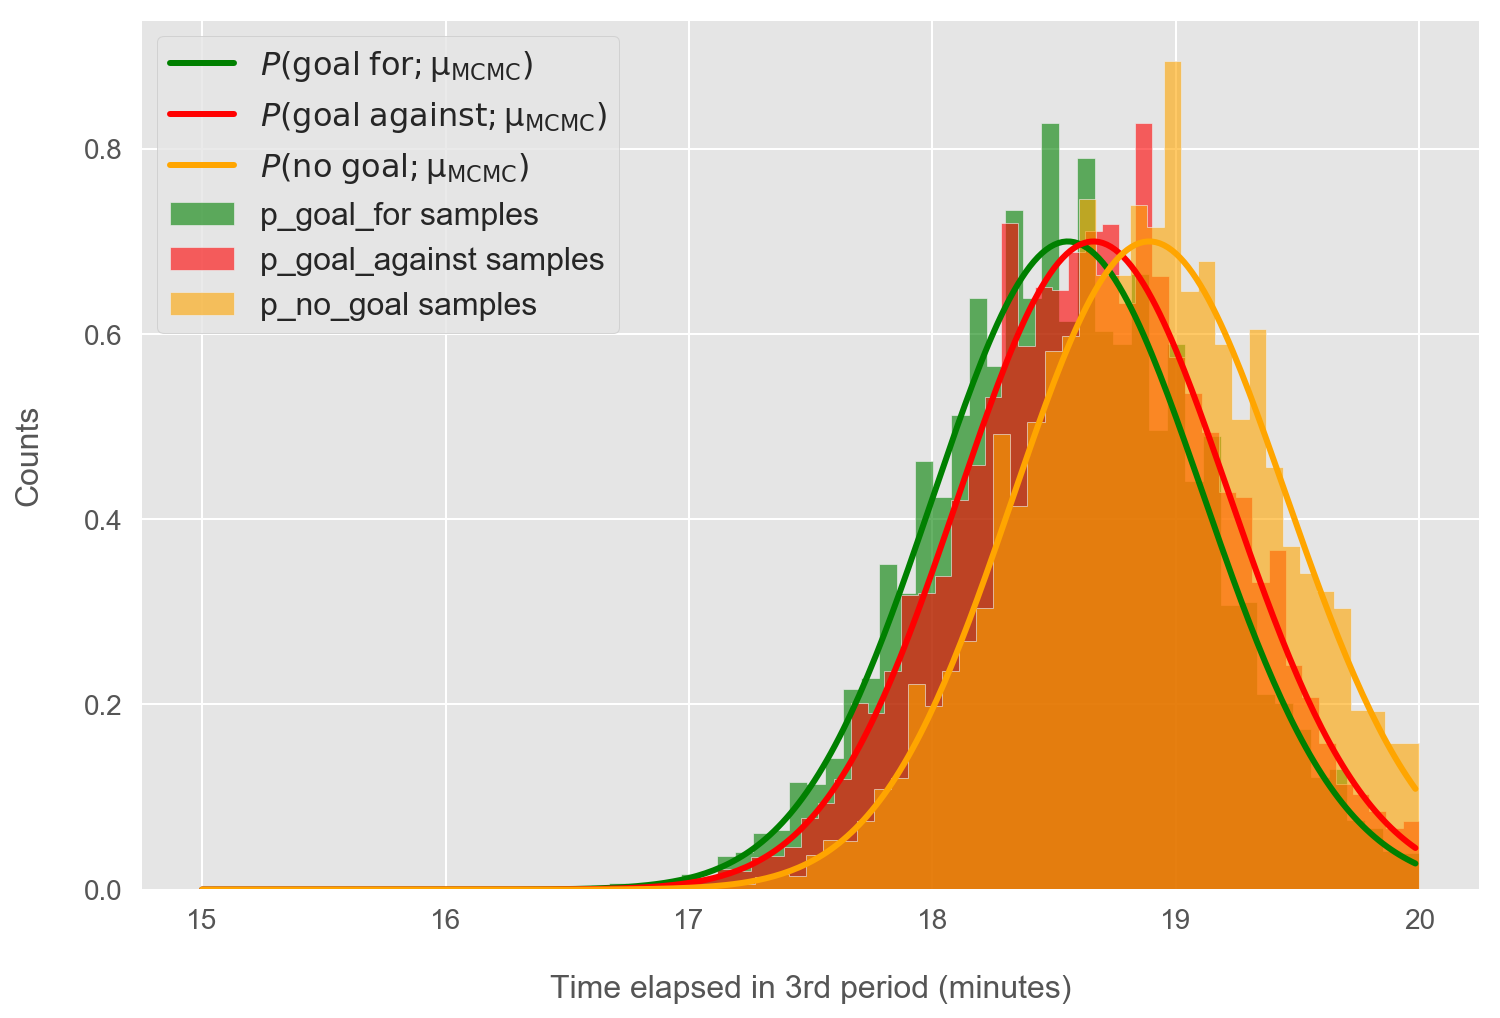

In [91]:
ALPHA = 0.6
LW = 3

''' Plot MCMC samples '''

plt.hist(burned_trace['p_goal_for']/60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against']/60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_no_goal']/60, bins=50,
         color='orange', label='p_no_goal samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot poisson distributions '''
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior([
    burned_trace['mu_goal_for'].mean(),
    burned_trace['mu_goal_against'].mean(),
    burned_trace['mu_no_goal'].mean(),
])

# Rescale
scale_frac = 0.7
y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
y_goal_against = y_goal_against / y_goal_against.max() * scale_frac
y_no_goal = y_no_goal / y_no_goal.max() * scale_frac

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$P(\rm{no\;goal};\mu_{MCMC})$', color='orange', lw=LW)

''' Clean up the chart '''

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.legend()

savefig(plt, 'time_elapsed_poisson_mcmc_samples')

plt.show()

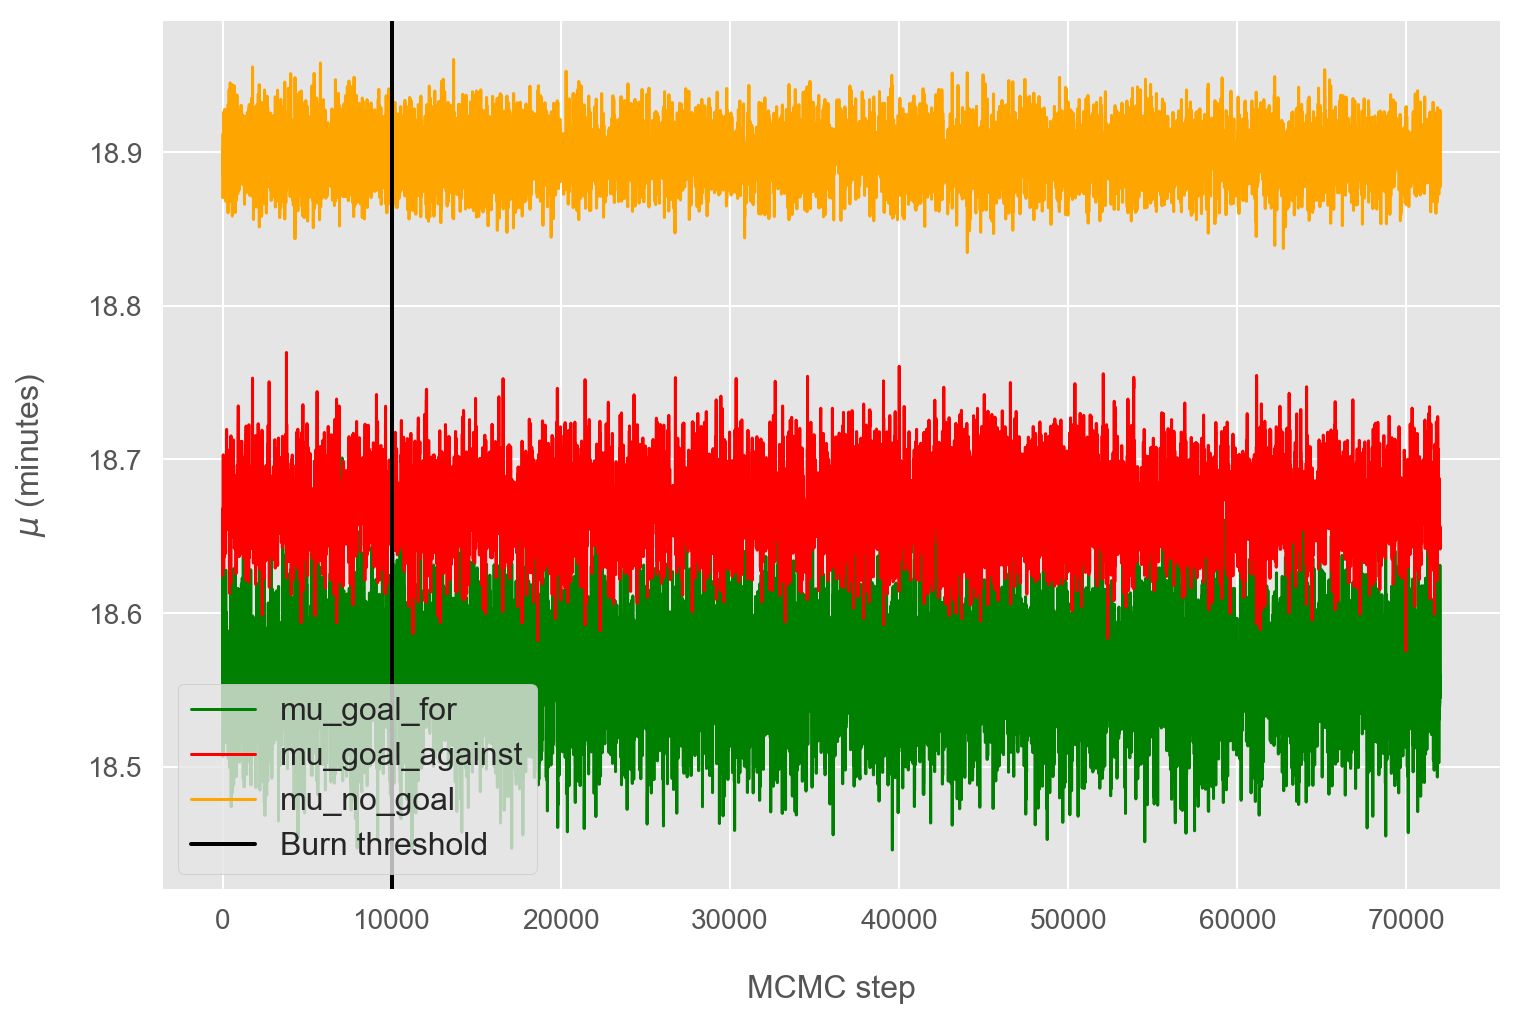

In [92]:
plt.plot(trace['mu_goal_for']/60, label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against']/60, label='mu_goal_against', color='red')
plt.plot(trace['mu_no_goal']/60, label='mu_no_goal', color='orange')
plt.ylabel('$\mu$ (minutes)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend()

savefig(plt, 'time_elapsed_mu_steps')

plt.show()

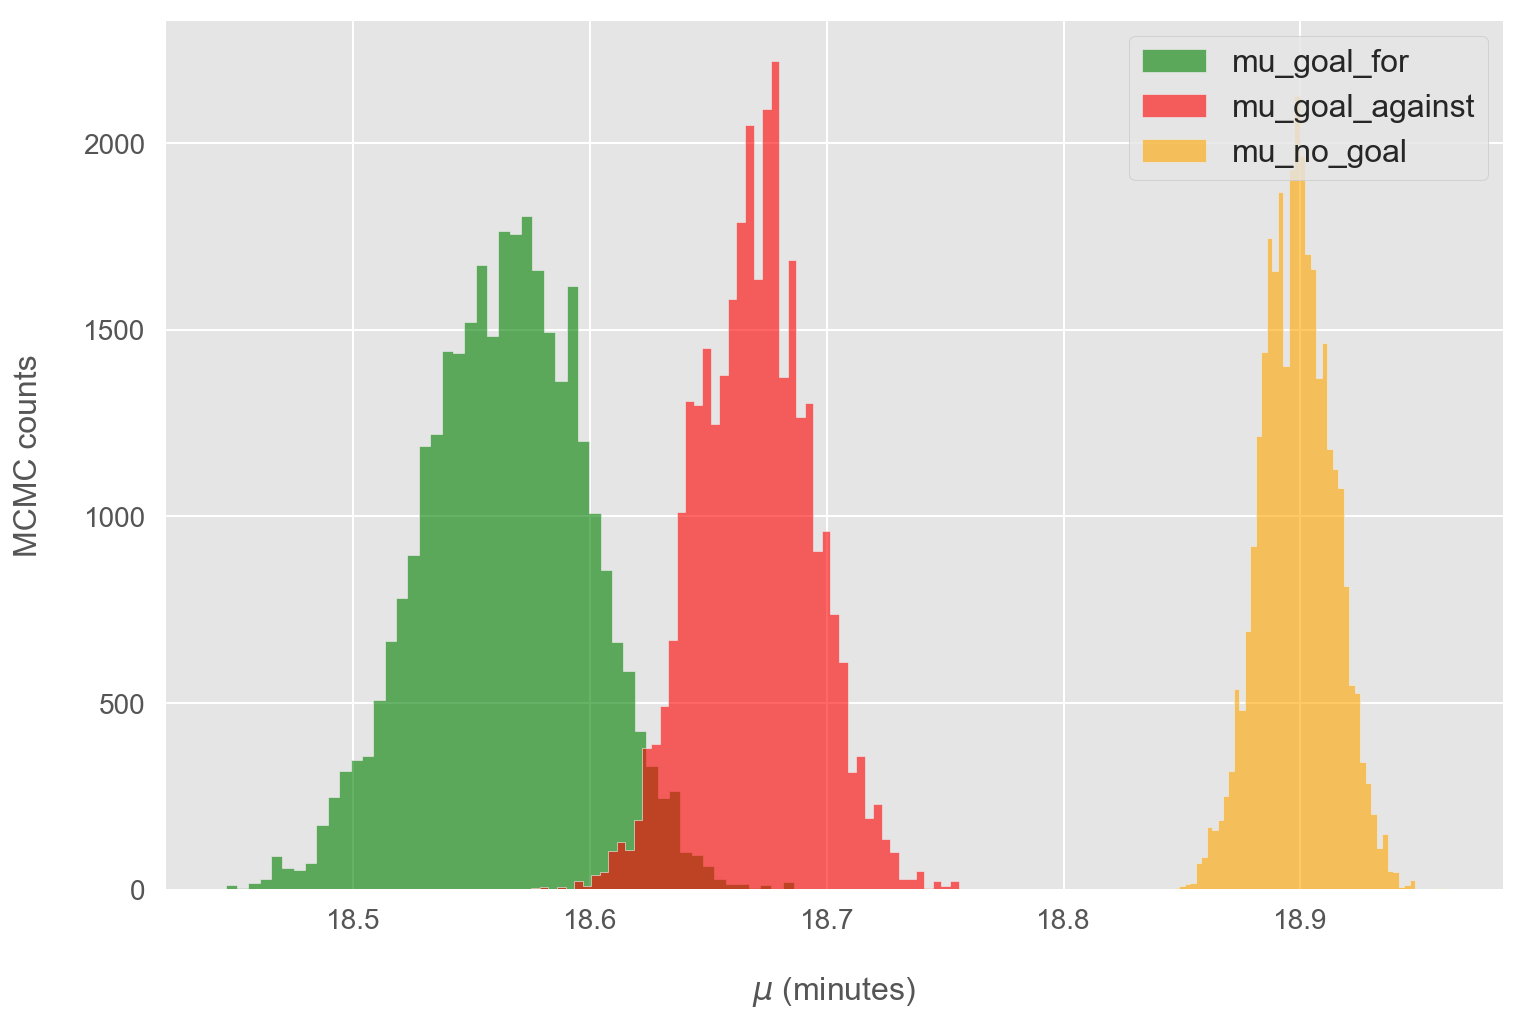

In [93]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for']/60, bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against']/60, bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_no_goal']/60, bins=50,
         color='orange', label='mu_no_goal',
         histtype='stepfilled', alpha=ALPHA)

plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (minutes)')
plt.legend()

savefig(plt, 'time_elapsed_mu_samples')
plt.show()

### Normalization

Now I need to normalize these. Let's confirm equal sample numbers

In [94]:
(burned_trace['mu_goal_for'].shape,
burned_trace['mu_goal_against'].shape,
burned_trace['mu_no_goal'].shape)

((32000,), (32000,), (32000,))

In [95]:
len(burned_trace) * 4

32000

Nice! Same number of samlpes. Weird that it's 4x my burned trace amount - probably due to 4 cores

Let's define the average shape parameter $\mu$ and then solve for the normalizing fractions.

In [96]:
mu_mcmc = [
    burned_trace['mu_goal_for'].mean(),
    burned_trace['mu_goal_against'].mean(),
    burned_trace['mu_no_goal'].mean(),
]

print(f'MCMC values for mu: {mu_mcmc}')

MCMC values for mu: [1113.8427579586273, 1120.1597483330797, 1133.911859778394]


In [97]:
mcmc_normalizing_factors = np.array([
    training_samples[0].shape[0],
     training_samples[1].shape[0],
     training_samples[2].shape[0]
])
mcmc_normalizing_factors = mcmc_normalizing_factors / mcmc_normalizing_factors.sum()

print(f'MCMC normalizing factors =\n{mcmc_normalizing_factors}')

MCMC normalizing factors =
[0.1268201  0.26021606 0.61296383]


In [98]:
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(mu_mcmc)

y_goal_for = y_goal_for * mcmc_normalizing_factors[0]
y_goal_against = y_goal_against * mcmc_normalizing_factors[1]
y_no_goal = y_no_goal * mcmc_normalizing_factors[2]

cutoff_renormed_factor = 2 - (y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum())
model_normalizing_factors = mcmc_normalizing_factors * cutoff_renormed_factor

print(f'Poisson normalizing factors =\n{model_normalizing_factors}')

Poisson normalizing factors =
[0.12928337 0.26527033 0.62486963]


Here's what the properly weighted samlpes look like:

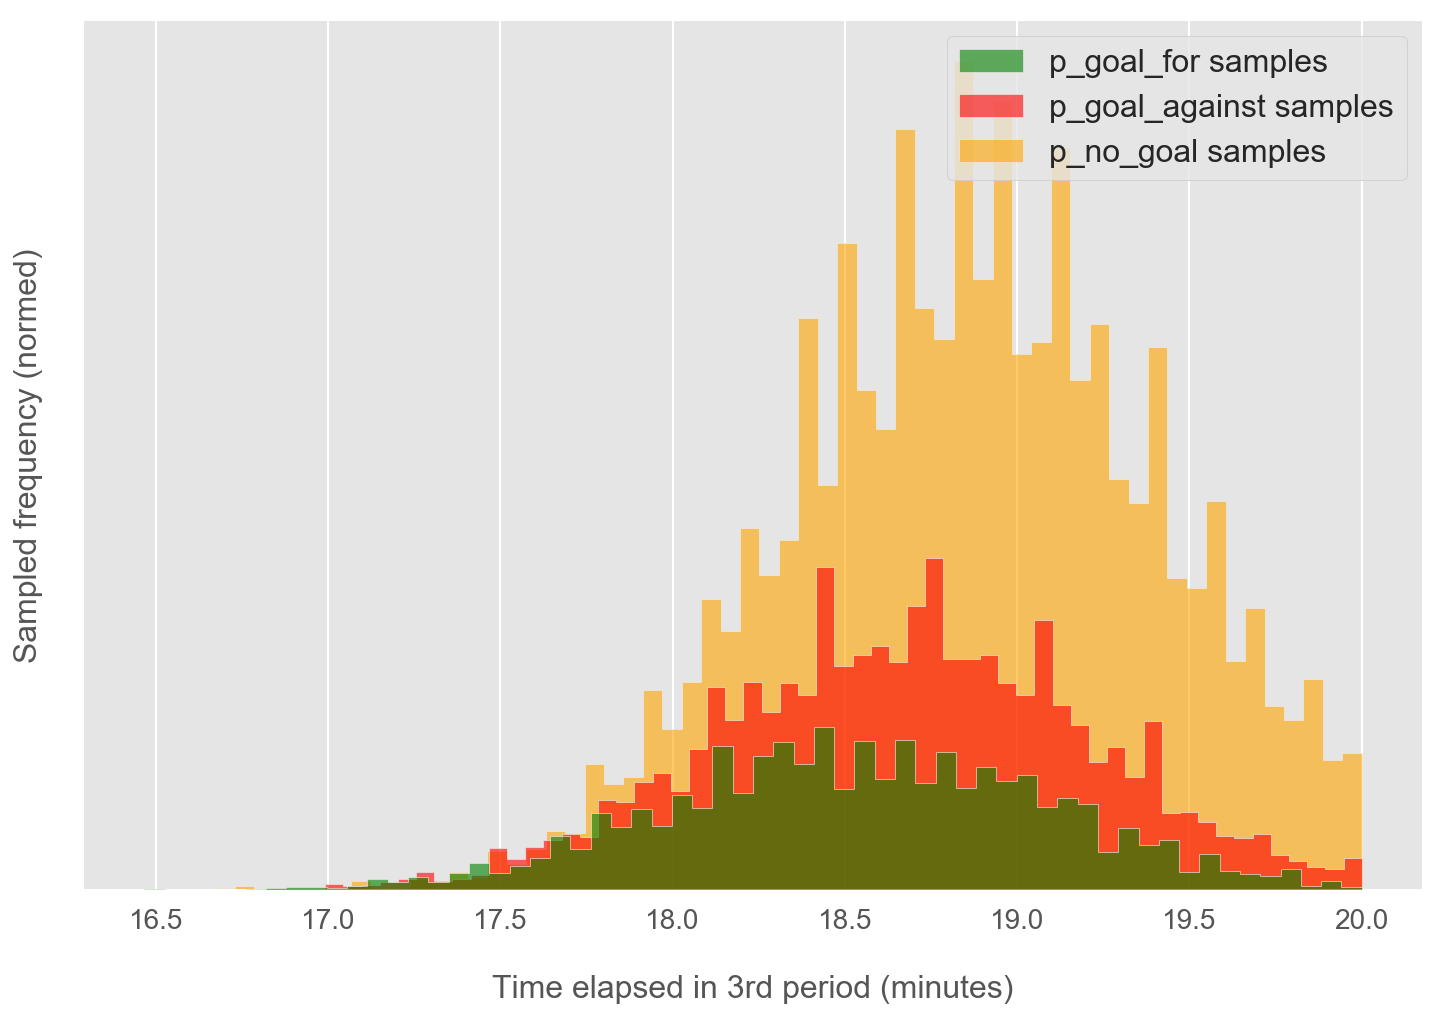

In [99]:
ALPHA = 0.6
LW = 3
BINS = 60

''' Plot the MCMC samples '''

plt.hist(np.random.choice(
            burned_trace['p_goal_for'] / 60,
            size=int(burned_trace['p_goal_for'].shape[0] * mcmc_normalizing_factors[0])
         ),
         bins=BINS, color='green', label='p_goal_for samples',
         histtype='stepfilled', alpha=ALPHA, zorder=3)

plt.hist(np.random.choice(
            burned_trace['p_goal_against'] / 60,
            size=int(burned_trace['p_goal_against'].shape[0] * mcmc_normalizing_factors[1])
         ),
         bins=BINS,
         color='red', label='p_goal_against samples',
         histtype='stepfilled', alpha=ALPHA, zorder=2)

plt.hist(np.random.choice(
            burned_trace['p_no_goal'] / 60,
            size=int(burned_trace['p_no_goal'].shape[0] * mcmc_normalizing_factors[2])
         ),
         bins=BINS,
         color='orange', label='p_no_goal samples',
         histtype='stepfilled', alpha=ALPHA)

plt.ylabel('Sampled frequency (normed)')
plt.yticks([])
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.legend();

savefig(plt, 'time_elapsed_normed_poisson_mcmc_samples')

plt.show()

### Normalized Posteriors

Re-normalize for cutoff Poisson distributions

In [100]:
import inspect
print(inspect.getsource(poisson_posterior))

def poisson_posterior(
    mu=None,
    norm_factors=None,
) -> Tuple[np.ndarray]:

    p = poisson.pmf
    x = np.arange(15*60, 20*60, 1)
    if mu is None:
        return (x / 60,)
    
    mu_goal_for = mu[0]
    mu_goal_against = mu[1]
    mu_no_goal = mu[2]

    y_goal_for = p(x, mu_goal_for)
    y_goal_against = p(x, mu_goal_against)
    y_no_goal = p(x, mu_no_goal)
    
    if norm_factors is not None:
        y_goal_for = p(x, mu_goal_for) * norm_factors[0]
        y_goal_against = p(x, mu_goal_against) * norm_factors[1]
        y_no_goal = p(x, mu_no_goal) * norm_factors[2]
    
    # Convert into minutes
    x = x / 60

    return x, y_goal_for, y_goal_against, y_no_goal



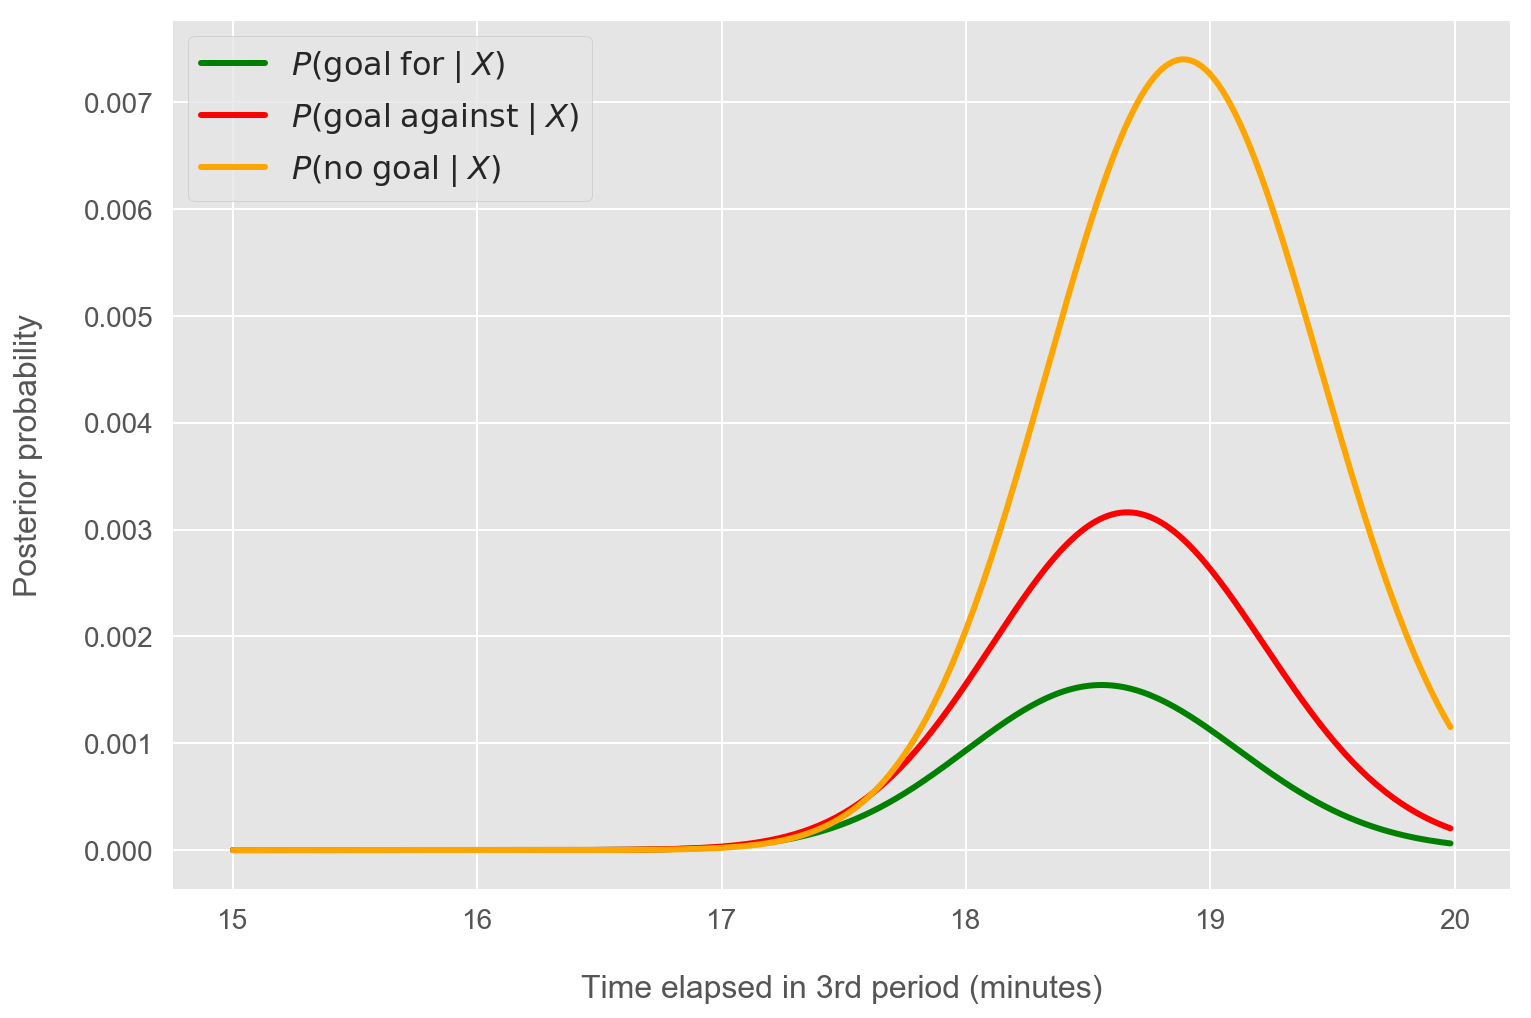

In [101]:
from scipy.stats import poisson
ALPHA = 0.6
LW = 3 

''' Plot the poisson distributions '''
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)
plt.plot(x, y_goal_for, label=r'$P(\mathrm{goal\;for}\;|\;X)$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\mathrm{goal\;against}\;|\;X)$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$P(\mathrm{no\;goal}\;|\;X)$', color='orange', lw=LW)

plt.ylabel('Posterior probability')
# plt.yticks([])
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.legend()

savefig(plt, 'time_elapsed_normed_poisson')

plt.show()

### Interpretation

In [102]:
def convert_to_time_remaining(x):
    _x = 20 - x
    t = datetime.timedelta(seconds=_x*60)
    return str(t)

convert_to_time_remaining(x[np.argmax(y_goal_for)])

'0:01:27'

In [103]:
print('Time of max posterior probability =\n'
      f'{x[np.argmax(y_goal_for)], x[np.argmax(y_goal_against)], x[np.argmax(y_no_goal)]}')

print()

t_remaining = [convert_to_time_remaining(x[np.argmax(y_goal_for)]),
              convert_to_time_remaining(x[np.argmax(y_goal_against)]),
              convert_to_time_remaining(x[np.argmax(y_no_goal)])]

print(f'Time of max posterior probability =\n{t_remaining}')

Time of max posterior probability =
(18.55, 18.666666666666668, 18.883333333333333)

Time of max posterior probability =
['0:01:27', '0:01:20', '0:01:07']


Great, now we have properly normalized probabilties.

Notes:
 - From normalizing factors, we can see ~12% chance of scoring when pulling the goalie on average.
 - Probability of scoring peaks at 18.55 mins (1:27 remaining), with other probabilties following close after (01:20 for goal against and 01:07 for no goals)
 
From now on we'll work from the distributions as our source of truth. These are hard coded below to help with reproducibility.

In [104]:
model_normlizing_factors = [
    0.1292882,
    0.26528024,
    0.62489297,
]

mu_mcmc = [
    1113.8279468130681,
    1120.1830172722719,
    1133.9420018554083
]

### Cumulative sum

Calculating the CDF will allow us to make some interesting observations on the results.

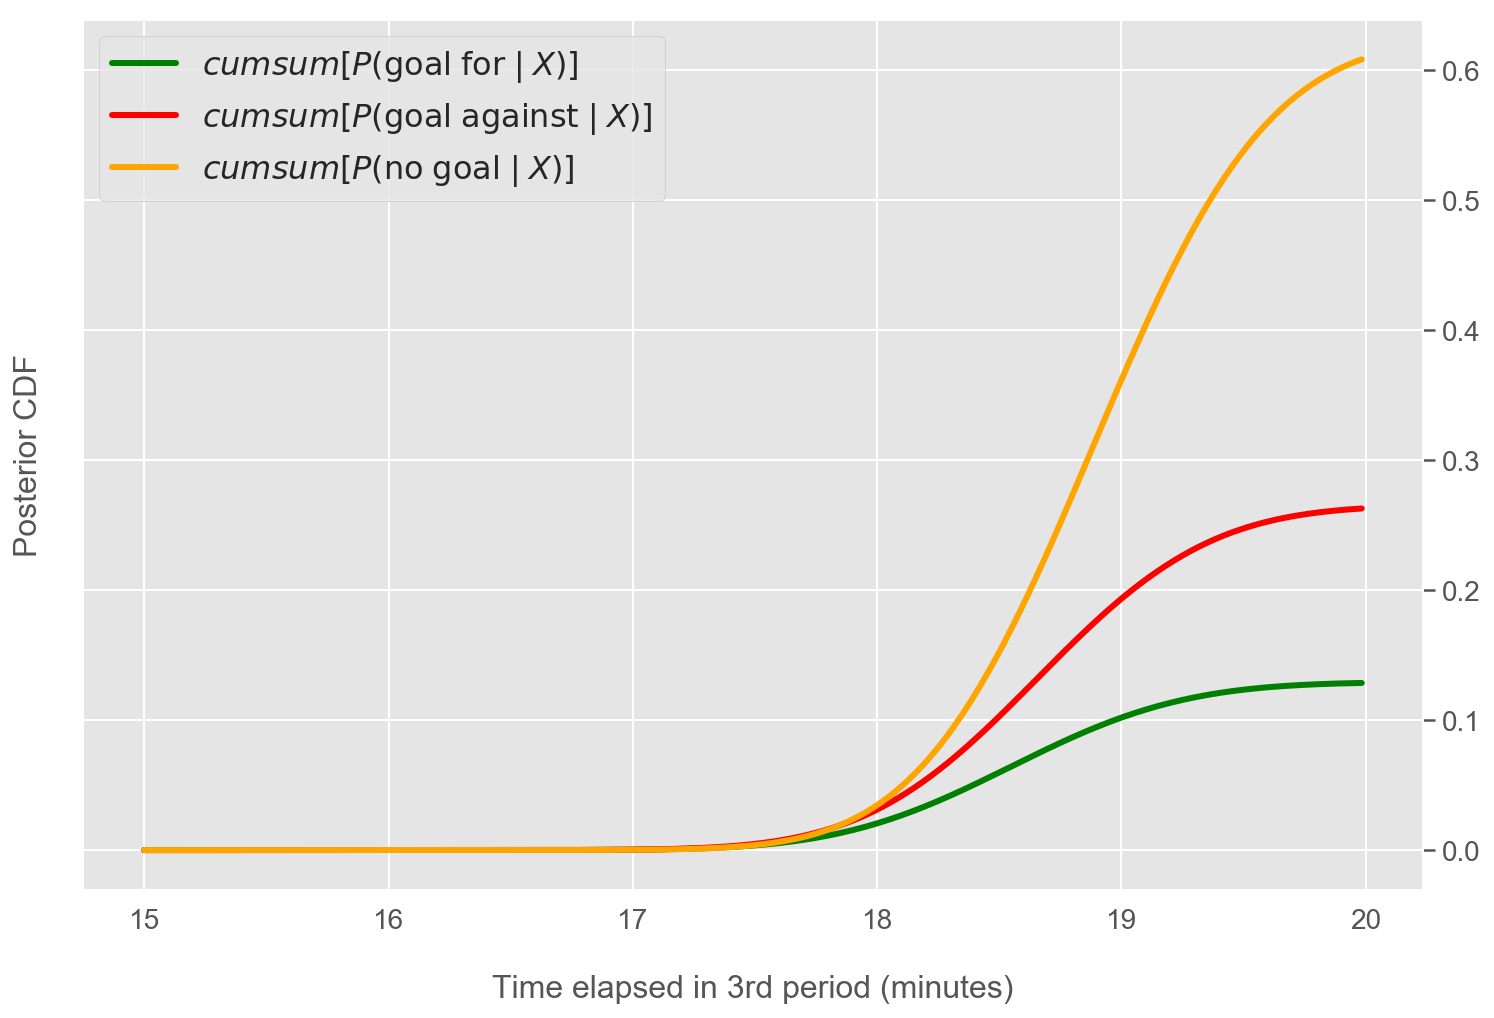

In [105]:
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)

plt.plot(x, np.cumsum(y_goal_for), label=r'$cumsum [ P(\mathrm{goal\;for}\;|\;X) ]$', color='green', lw=LW)
plt.plot(x, np.cumsum(y_goal_against), label=r'$cumsum [ P(\mathrm{goal\;against}\;|\;X) ]$', color='red', lw=LW)
plt.plot(x, np.cumsum(y_no_goal), label=r'$cumsum [ P(\mathrm{no\;goal}\;|\;X) ]$', color='orange', lw=LW)

plt.ylabel('Posterior CDF')
# plt.yticks([])
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.legend()

ax = plt.gca()
ax.yaxis.tick_right()

savefig(plt, 'time_elapsed_poisson_cdf')

plt.show()

The end of game values have been normalized sum up to one, but this ratio changes over time. We can visualize this with the risk-reward ratio (see below).

### Re-normalize

To better compare these probability distributions, we can normalize each bin to 1 using a function $\alpha(t)$, as follows:

$$
\alpha(t) \cdot \big[ P(goal\;for; t) + (P(goal\;against; t) + P(no\;goal; t)\big] = 1 \\
\vdots \\
\alpha(t) = \big[ P(goal\;for; t) + (P(goal\;against; t) + P(no\;goal; t)\big]^{-1}
$$

This will allow us to re-weight the posteriors later, so we can compare them better and yield a different interpretation.

Essentially, we'll be able to interpret the resulting distribution as the chance of each outcome at time $t$. This stands in contrast to the probability distributions above, where the total area under the curves sum to 1.

In [106]:
alpha = np.power(
    np.sum([y_goal_for, y_goal_against, y_no_goal], axis=0),
    -1
)

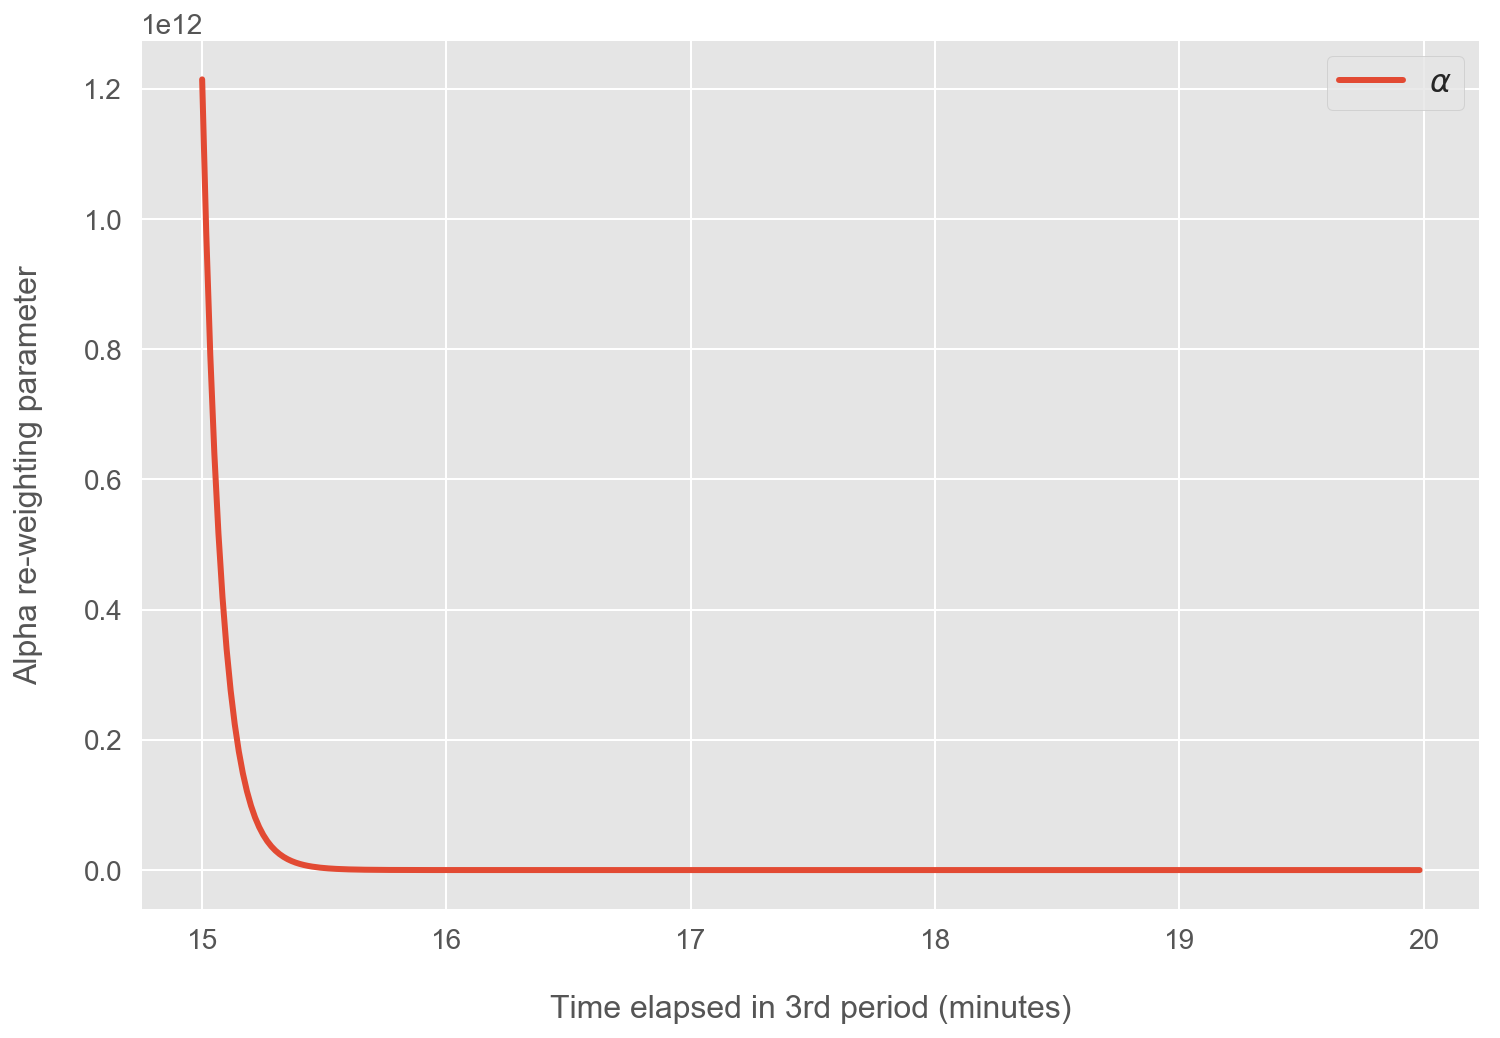

In [107]:
plt.plot(x, alpha, label=r'$\alpha$', lw=LW)
plt.ylabel('Alpha re-weighting parameter')
# plt.yticks([])
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.legend()

# savefig(plt, 'time_elapsed_poisson_cdf')

plt.show()

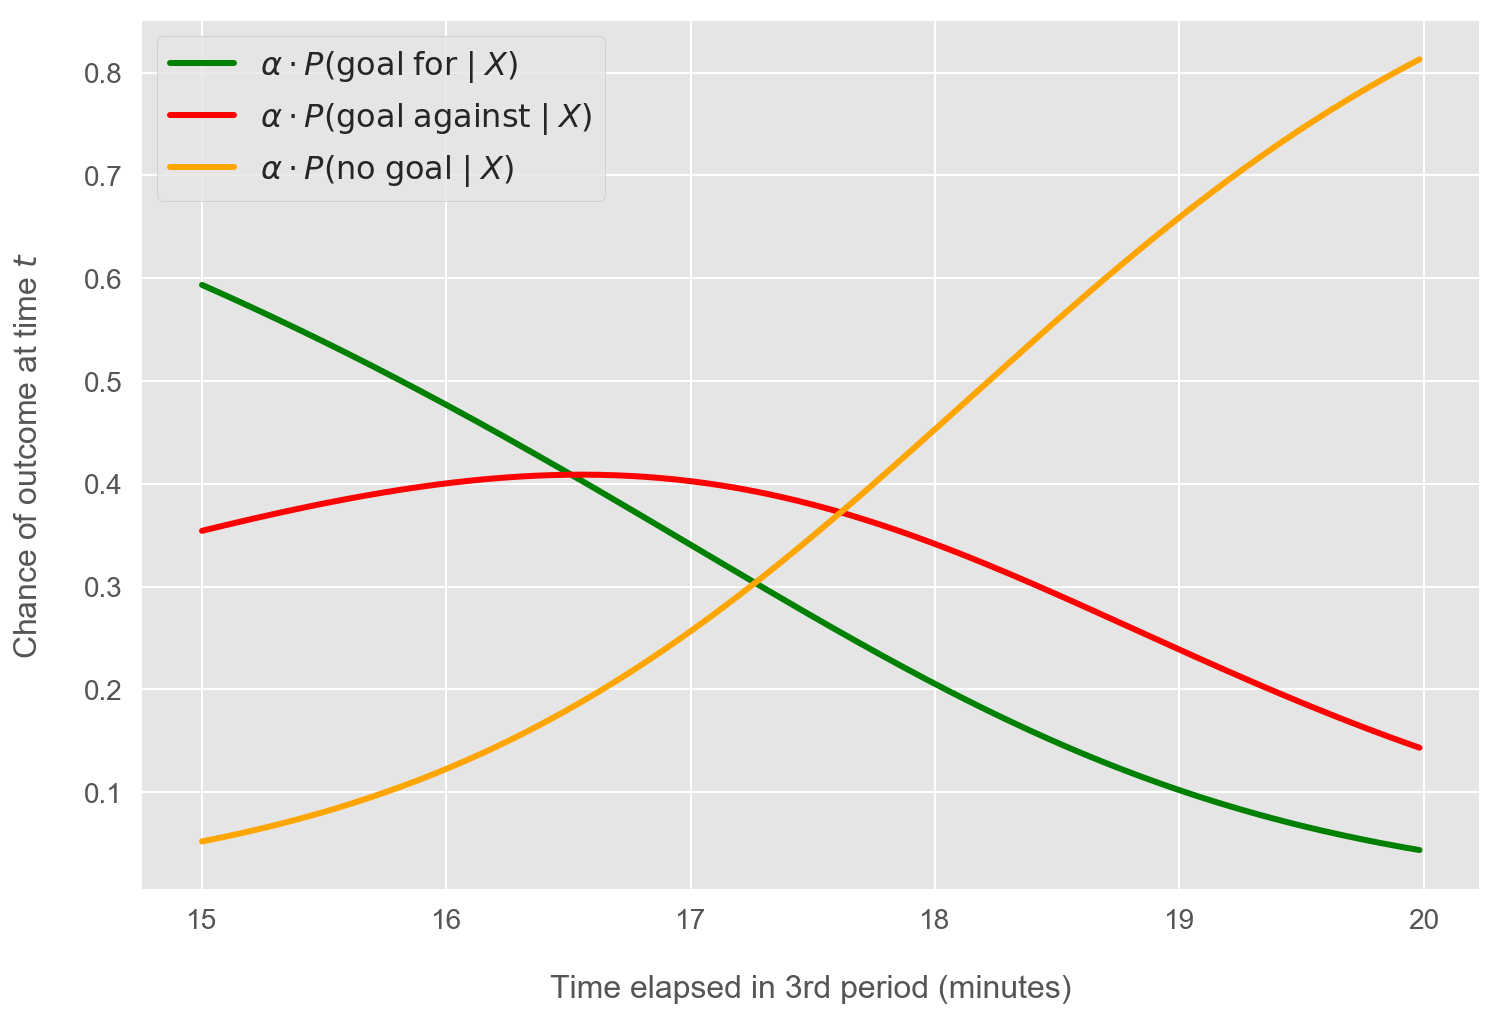

In [108]:
from scipy.stats import poisson
ALPHA = 0.6
LW = 3 

''' Plot the poisson distributions '''
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)

# Alpha has same shape as x, y above
alpha = np.power(
    np.sum([y_goal_for, y_goal_against, y_no_goal], axis=0),
    -1
)

y_goal_for = alpha * y_goal_for
y_goal_against = alpha * y_goal_against
y_no_goal = alpha * y_no_goal
plt.plot(x, y_goal_for, label=r'$\alpha \cdot P(\mathrm{goal\;for}\;|\;X)$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$\alpha \cdot P(\mathrm{goal\;against}\;|\;X)$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$\alpha \cdot P(\mathrm{no\;goal}\;|\;X)$', color='orange', lw=LW)

plt.ylabel('Chance of outcome at time $t$')
# plt.yticks([])
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.legend()

# Plotting below with error bar
# savefig(plt, 'time_elapsed_outcome_chance_timeseries')

plt.show()

### Adding error bars

Note how there are very few samples to draw conclusions from for the low and high times.

e.g. less than 17

In [109]:
np.sum(training_samples[0] < 17*60) + np.sum(training_samples[1] < 17*60) + np.sum(training_samples[2] < 17*60)

48

more than 17

In [110]:
np.sum(training_samples[0] > 17*60) + np.sum(training_samples[1] > 17*60) + np.sum(training_samples[2] > 17*60)

2081

We can show this uncertainty visually using error bars. Starting with the $\mu$ MCMC samples...

(array([5.000e+01, 6.740e+02, 2.282e+03, 6.986e+03, 9.296e+03, 7.382e+03,
        4.091e+03, 1.092e+03, 1.430e+02, 4.000e+00]),
 array([1130.64803593, 1131.34499674, 1132.04195754, 1132.73891834,
        1133.43587914, 1134.13283994, 1134.82980075, 1135.52676155,
        1136.22372235, 1136.92068315, 1137.61764395]),
 <a list of 10 Patch objects>)

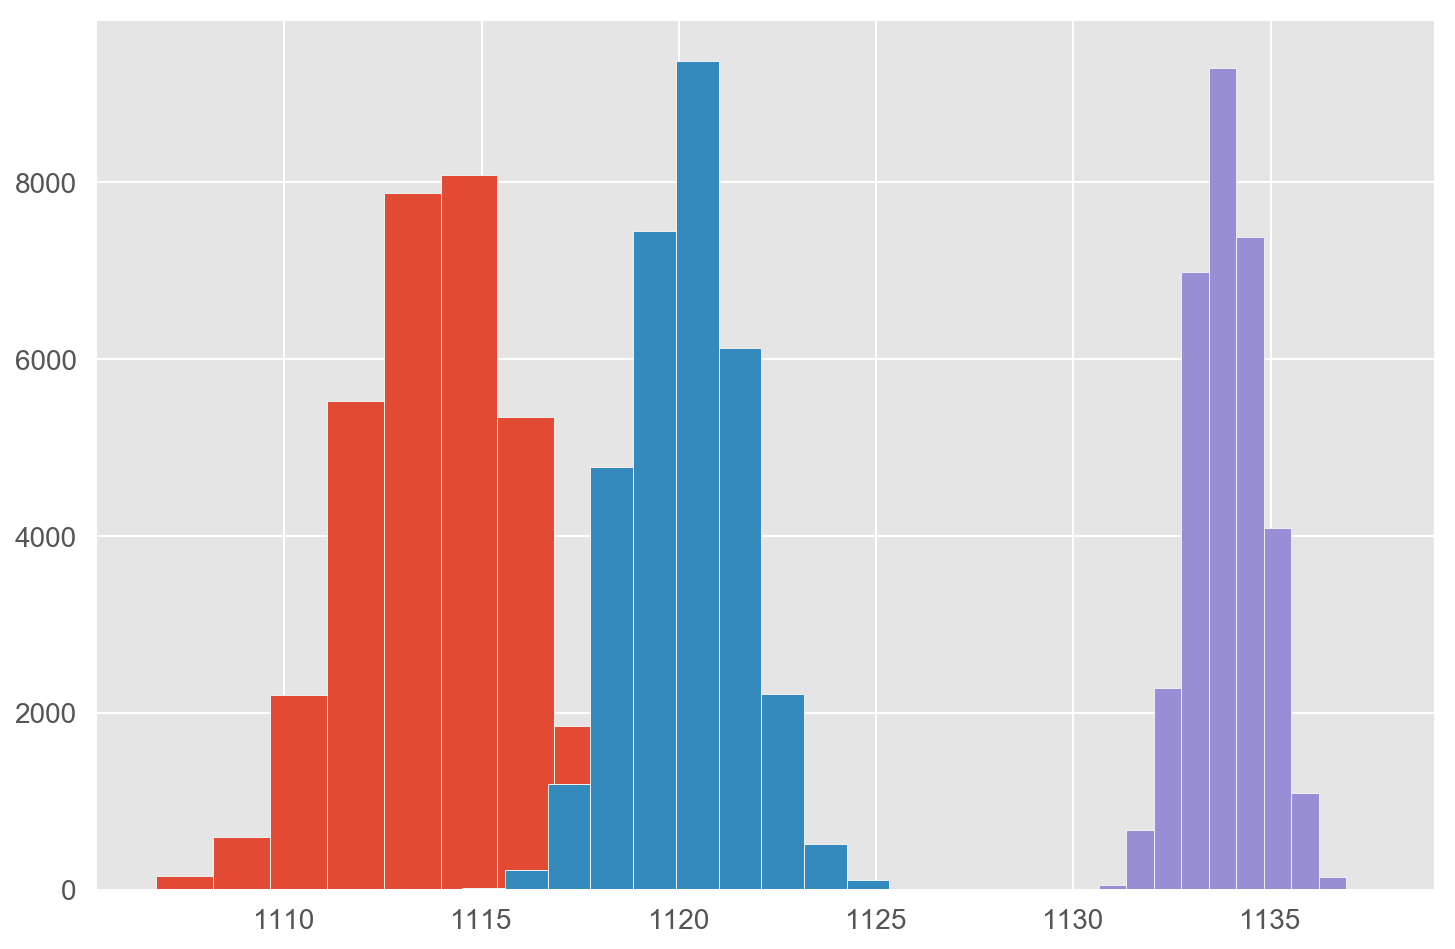

In [111]:
plt.hist(burned_trace['mu_goal_for'])
plt.hist(burned_trace['mu_goal_against'])
plt.hist(burned_trace['mu_no_goal'])

We can use the uncertainty on $\mu$ to calculate that for $P$:

$$
\sigma_P = \big| \frac{\partial P}{\partial \mu} \big|\;\sigma_{\mu}
$$

where $\sigma_{\mu}$ is the standard deviation of the $\mu$ samples.

In [112]:
mu_mcmc_std = [
    burned_trace['mu_goal_for'].std(),
    burned_trace['mu_goal_against'].std(),
    burned_trace['mu_no_goal'].std(),
]

In [113]:
mu_mcmc_std

[2.0603941307684237, 1.441301866154284, 0.918582767773563]

In [114]:
model_normalizing_factors

array([0.12928337, 0.26527033, 0.62486963])

In [115]:
from scipy.misc import derivative
from tqdm import tqdm_notebook

def calc_posteror_error(mu, mu_std, mu_step=1e-6):
    x = poisson_posterior()[0] * 60 # convert back into seconds (discrete)
    err = mu_std * np.abs(np.array([
        derivative(lambda _mu: poisson.pmf(int(t), _mu), mu, dx=mu_step)
        for t in tqdm_notebook(x)
    ]))
    return err

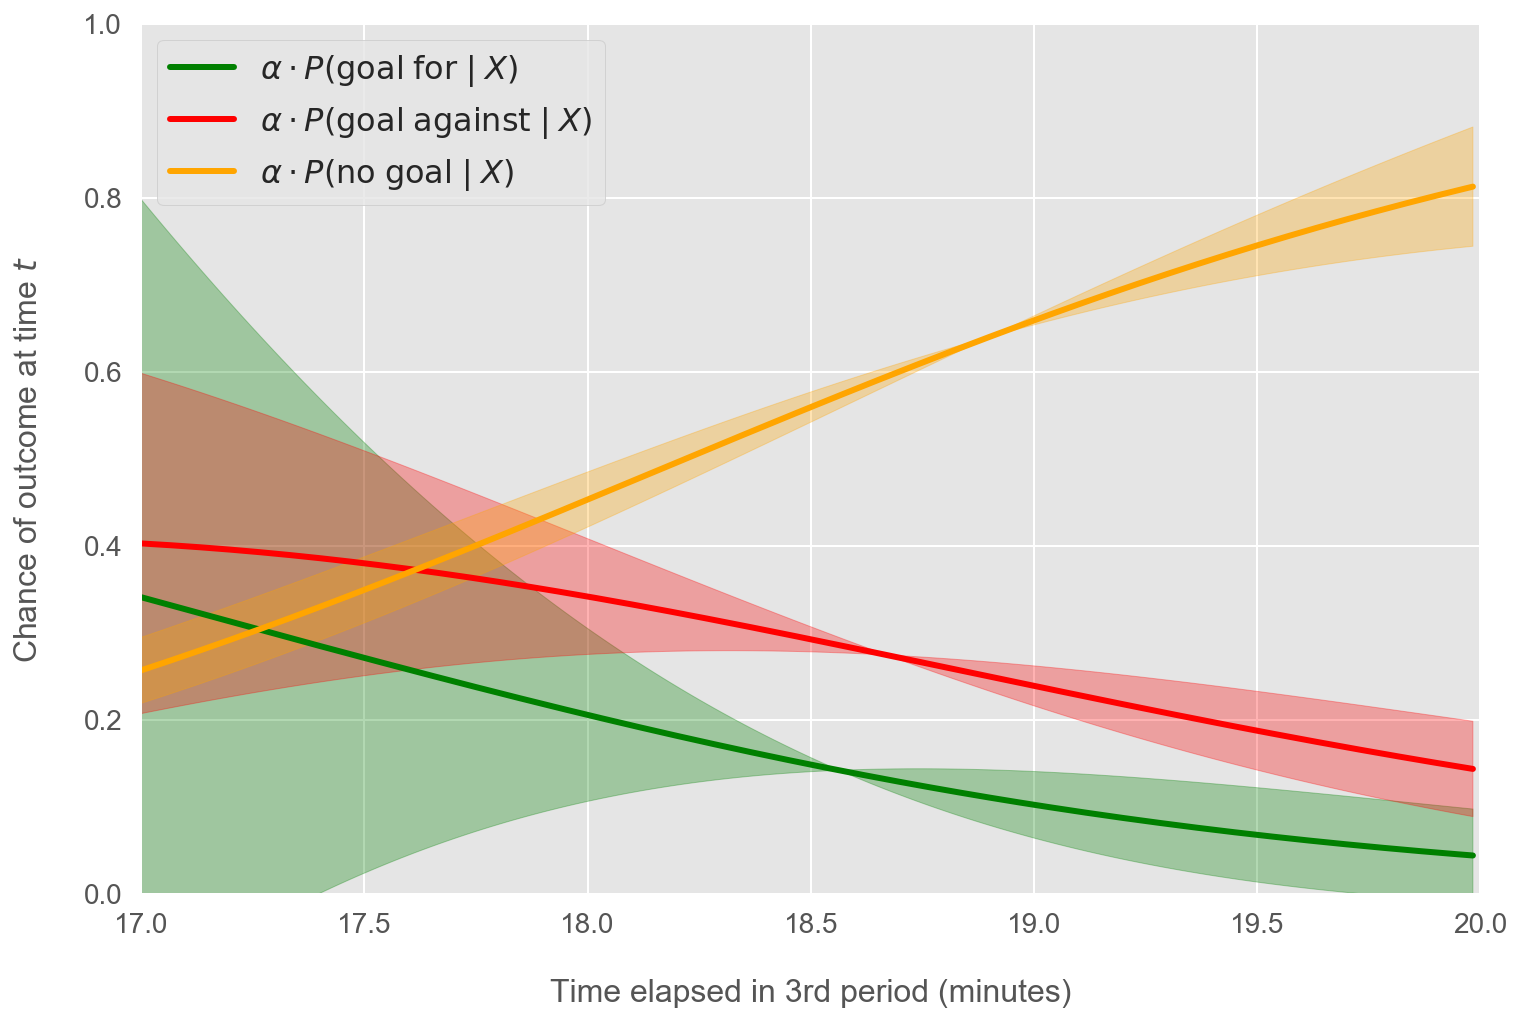

In [116]:
from scipy.stats import poisson
ALPHA = 0.6
ALPHA_LIGHT = 0.3
LW = 3

''' Plot the poisson distributions '''
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)

# Alpha has same shape as x, y above
alpha = np.power(
    np.sum([y_goal_for, y_goal_against, y_no_goal], axis=0),
    -1
)

y_goal_for = alpha * y_goal_for
y_goal_against = alpha * y_goal_against
y_no_goal = alpha * y_no_goal
plt.plot(x, y_goal_for, label=r'$\alpha \cdot P(\mathrm{goal\;for}\;|\;X)$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$\alpha \cdot P(\mathrm{goal\;against}\;|\;X)$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$\alpha \cdot P(\mathrm{no\;goal}\;|\;X)$', color='orange', lw=LW)

''' Plot the errors '''
err_p_goal_for = alpha * calc_posteror_error(mu_mcmc[0], mu_mcmc_std[0])
err_p_goal_against = alpha * calc_posteror_error(mu_mcmc[1], mu_mcmc_std[1])
err_p_no_goal = alpha * calc_posteror_error(mu_mcmc[2], mu_mcmc_std[2])
plt.fill_between(x, y_goal_for-err_p_goal_for, y_goal_for+err_p_goal_for,
                 color='green', alpha=ALPHA_LIGHT)
plt.fill_between(x, y_goal_against-err_p_goal_against, y_goal_against+err_p_goal_against,
                 color='red', alpha=ALPHA_LIGHT)
plt.fill_between(x, y_no_goal-err_p_no_goal, y_no_goal+err_p_no_goal,
                 color='orange', alpha=ALPHA_LIGHT)

plt.ylabel('Chance of outcome at time $t$')
# plt.yticks([])
plt.xlabel('Time elapsed in 3rd period (minutes)')
plt.xlim(17, 20)
plt.ylim(0, 1)
plt.legend()

savefig(plt, 'time_elapsed_poisson_outcome_chances')

plt.show()

We can't say anything conclusive due to huge errors on low times, but we are much more confident on late game predictions

### Odds of scoring a goal
Let's go into odds-space and look at the chance of scoring a goal, compared to either outcome. We want to maximze this.

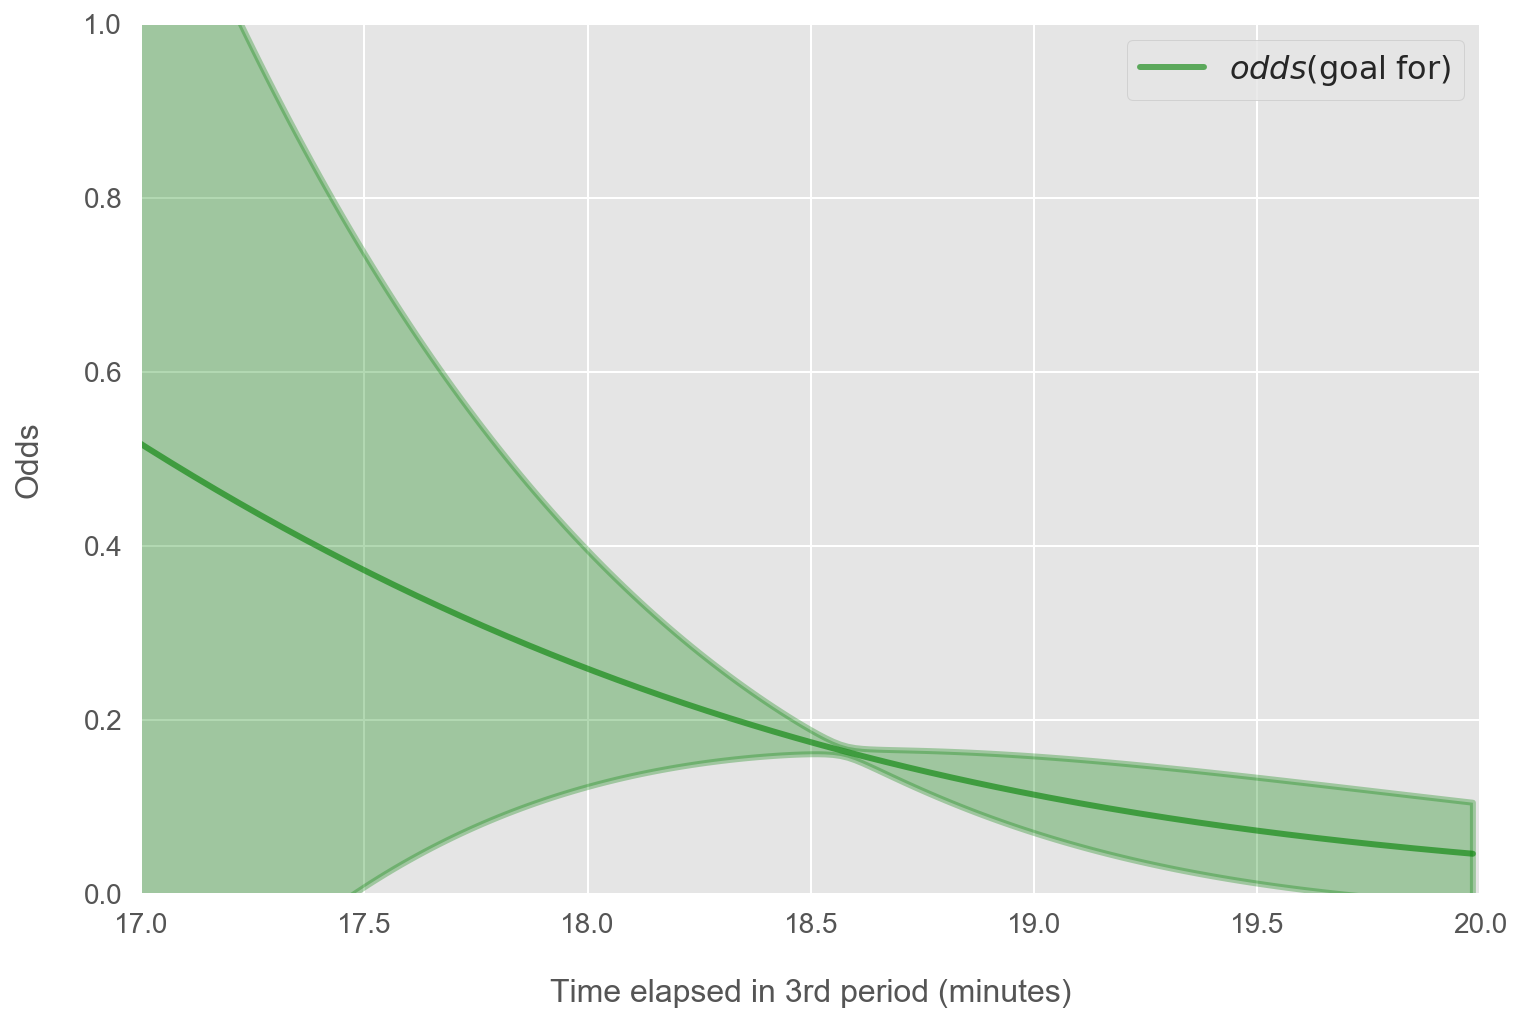

In [117]:
ALPHA = 0.6
ALPHA_LIGHT = 0.3
LW = 3

''' Odds ratio '''

x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)

odds_goal_for = y_goal_for / (y_goal_against + y_no_goal)

''' Error bars '''

err_p_goal_for = calc_posteror_error(mu_mcmc[0], mu_mcmc_std[0])
err_p_goal_against = calc_posteror_error(mu_mcmc[1], mu_mcmc_std[1])
err_p_no_goal = calc_posteror_error(mu_mcmc[2], mu_mcmc_std[2])
err_odds_goal_for = (
    np.power(err_p_goal_for / y_goal_for, 2)
    + np.power(err_p_goal_against / y_goal_against, 2)
    + np.power(err_p_no_goal / y_no_goal, 2)
)
err_odds_goal_for = odds_goal_for * np.sqrt(err_odds_goal_for)

''' Plots '''

plt.plot(x, odds_goal_for,
         label=r'$odds(\mathrm{goal\;for})$',
         color='green', lw=LW, alpha=ALPHA)
plt.fill_between(x, odds_goal_for-err_odds_goal_for, odds_goal_for+err_odds_goal_for,
                 color='green', lw=LW, alpha=ALPHA_LIGHT)

plt.ylabel('Odds')
# plt.yticks([])
plt.xlabel('Time elapsed in 3rd period (minutes)')

plt.xlim(17, 20)
plt.ylim(0, 1)

plt.legend()

savefig(plt, 'time_elapsed_poisson_odds_goal_for')

plt.show()

In [118]:
(odds_goal_for-err_odds_goal_for).max()

0.16020730942261444

This chart suggests that odds of scoring are highest when the goalie is pulled before the 18.5 minute mark. Although the odds of scoring trend up as $t$ gets smaller, there's no statistically significant evidence for odds greater than 16%.

## Model 2 - Time since goalie pull

The work thus far has been to model the outcomes as a function of "time 
elapsed". Now we'll shift our attention to "time since goalie pull".

In [119]:
import inspect
print(inspect.getsource(load_training_samples))

def load_training_samples(
    df,
    cols,
    masks=[],
    dtype='timedelta64[s]'
) -> np.ndarray:
    '''
    Return buckets of training data.
    '''
    if not masks:
        masks = [None] * len(cols)
    out = []
    for col, m in zip(cols, masks):
        if m is None:
            d = df[col].dropna().astype(dtype).values
        else:
            d = df[col][m].dropna().astype(dtype).values
        out.append(d)
        print(f'Loaded {len(d)} samples for col {col}')

    out = np.array(out)
    print(f'Training data shape = {out.shape}')
    return out



In [120]:
df.head()

season game_number team_name       date  pull_period pull_time  \
0  20032004         710       CHI 2004-01-21            3  00:19:44   
1  20032004         205       MIN 2003-11-08            3  00:19:58   
2  20032004        1230       S.J 2004-04-04            3  00:18:39   
3  20032004         655       PHX 2004-01-13            3  00:19:03   
4  20032004         985       PHX 2004-03-02            3  00:18:34   

  goal_for_time goal_against_time goal_for_timedelta goal_against_timedelta  \
0           NaT          00:19:47                NaT               00:00:03   
1           NaT               NaT                NaT                    NaT   
2      00:19:40               NaT           00:01:01                    NaT   
3           NaT          00:19:25                NaT               00:00:22   
4      00:18:44               NaT           00:00:10                    NaT   

  game_end_timedelta  
0                NaT  
1           00:00:02  
2                NaT  
3                NaT  
4                NaT

In [121]:
# Load time of pull for eventual outcomes:
feature_names = ['goal_for_timedelta', 'goal_against_timedelta', 'game_end_timedelta']
training_samples = load_training_samples(df=df, cols=feature_names)

Loaded 270 samples for col goal_for_timedelta
Loaded 554 samples for col goal_against_timedelta
Loaded 1305 samples for col game_end_timedelta
Training data shape = (3,)


In [122]:
(training_samples[0][:10],
training_samples[1][:10],
training_samples[2][:10],)

(array([61., 10., 48., 57., 37., 62., 30., 13., 27., 39.]),
 array([ 3., 22., 13., 36., 54., 44., 23., 11., 22.,  4.]),
 array([  2.,  75., 132.,  49.,  81.,  63.,  69.,  60.,   8.,  63.]))

In [123]:
feature_names

['goal_for_timedelta', 'goal_against_timedelta', 'game_end_timedelta']

### PyMC3 Model

In [124]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors for the mu parameter of the
        # Poisson distribution P.
        # Note: mu = mean(P)
        mu_goal_for = pm.Uniform(
            'mu_goal_for', 0, 5*60
        )
        mu_goal_against = pm.Uniform(
            'mu_goal_against', 0, 5*60
        )
        mu_no_goal = pm.Uniform(
            'mu_no_goal', 0, 5*60
        )
        
        # Observations to train the model on
        obs_goal_for = pm.Poisson(
            'obs_goal_for',
            mu=mu_goal_for,
            observed=training_samples[0],
        )
        obs_goal_against = pm.Poisson(
            'obs_goal_against',
            mu=mu_goal_against,
            observed=training_samples[1],
        )
        obs_no_goal = pm.Poisson(
            'obs_no_goal',
            mu=mu_no_goal,
            observed=training_samples[2],
        )
        
        # Outcome probabilities
        p_goal_for = pm.Bound(pm.Poisson, upper=5*60)('p_goal_for', mu=mu_goal_for)
        p_goal_against = pm.Bound(pm.Poisson, upper=5*60)('p_goal_against', mu=mu_goal_against)
        p_no_goal = pm.Bound(pm.Poisson, upper=5*60)('p_no_goal', mu=mu_no_goal)
        
        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_no_goal]
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_no_goal]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:31<00:00, 2378.15draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [125]:
N_burn = 10000
burned_trace = trace[N_burn:]

In [126]:
from typing import Tuple

def poisson_posterior(
    mu=None,
    norm_factors=None,
) -> Tuple[np.ndarray]:

    p = poisson.pmf
    x = np.arange(0, 5*60, 1)
    if mu is None:
#         return (x / 60,)
        return (x,)
    
    mu_goal_for = mu[0]
    mu_goal_against = mu[1]
    mu_no_goal = mu[2]

    y_goal_for = p(x, mu_goal_for)
    y_goal_against = p(x, mu_goal_against)
    y_no_goal = p(x, mu_no_goal)
    
    if norm_factors is not None:
        y_goal_for = p(x, mu_goal_for) * norm_factors[0]
        y_goal_against = p(x, mu_goal_against) * norm_factors[1]
        y_no_goal = p(x, mu_no_goal) * norm_factors[2]
    
    # Convert into minutes
#     x = x / 60

    return x, y_goal_for, y_goal_against, y_no_goal

### MCMC Samples

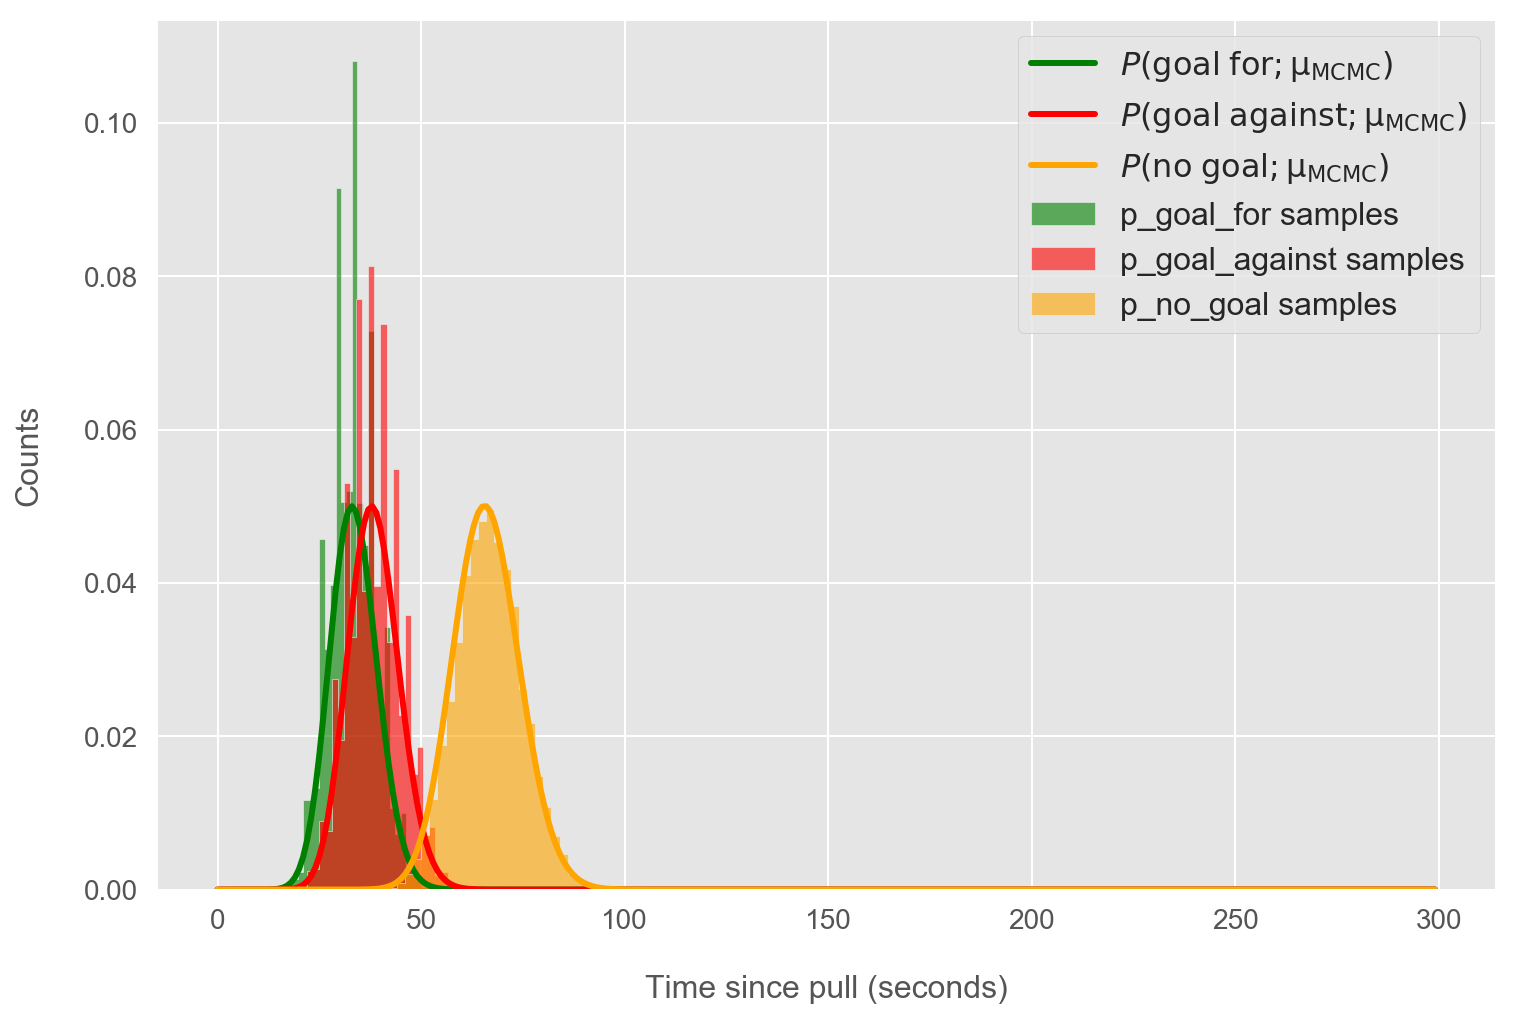

In [127]:
from scipy.stats import poisson

ALPHA = 0.6
LW = 3
BINS = 30

''' Plot MCMC samples '''

plt.hist(burned_trace['p_goal_for'], bins=BINS,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'], bins=BINS,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_no_goal'], bins=BINS,
         color='orange', label='p_no_goal samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot poisson distributions '''
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior([
    burned_trace['mu_goal_for'].mean(),
    burned_trace['mu_goal_against'].mean(),
    burned_trace['mu_no_goal'].mean(),
])

# Rescale
scale_frac = 0.05
y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
y_goal_against = y_goal_against / y_goal_against.max() * scale_frac
y_no_goal = y_no_goal / y_no_goal.max() * scale_frac

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$P(\rm{no\;goal};\mu_{MCMC})$', color='orange', lw=LW)

''' Clean up the chart '''

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Time since pull (seconds)')
plt.legend()

savefig(plt, 'time_since_poisson_mcmc_samples')

plt.show()

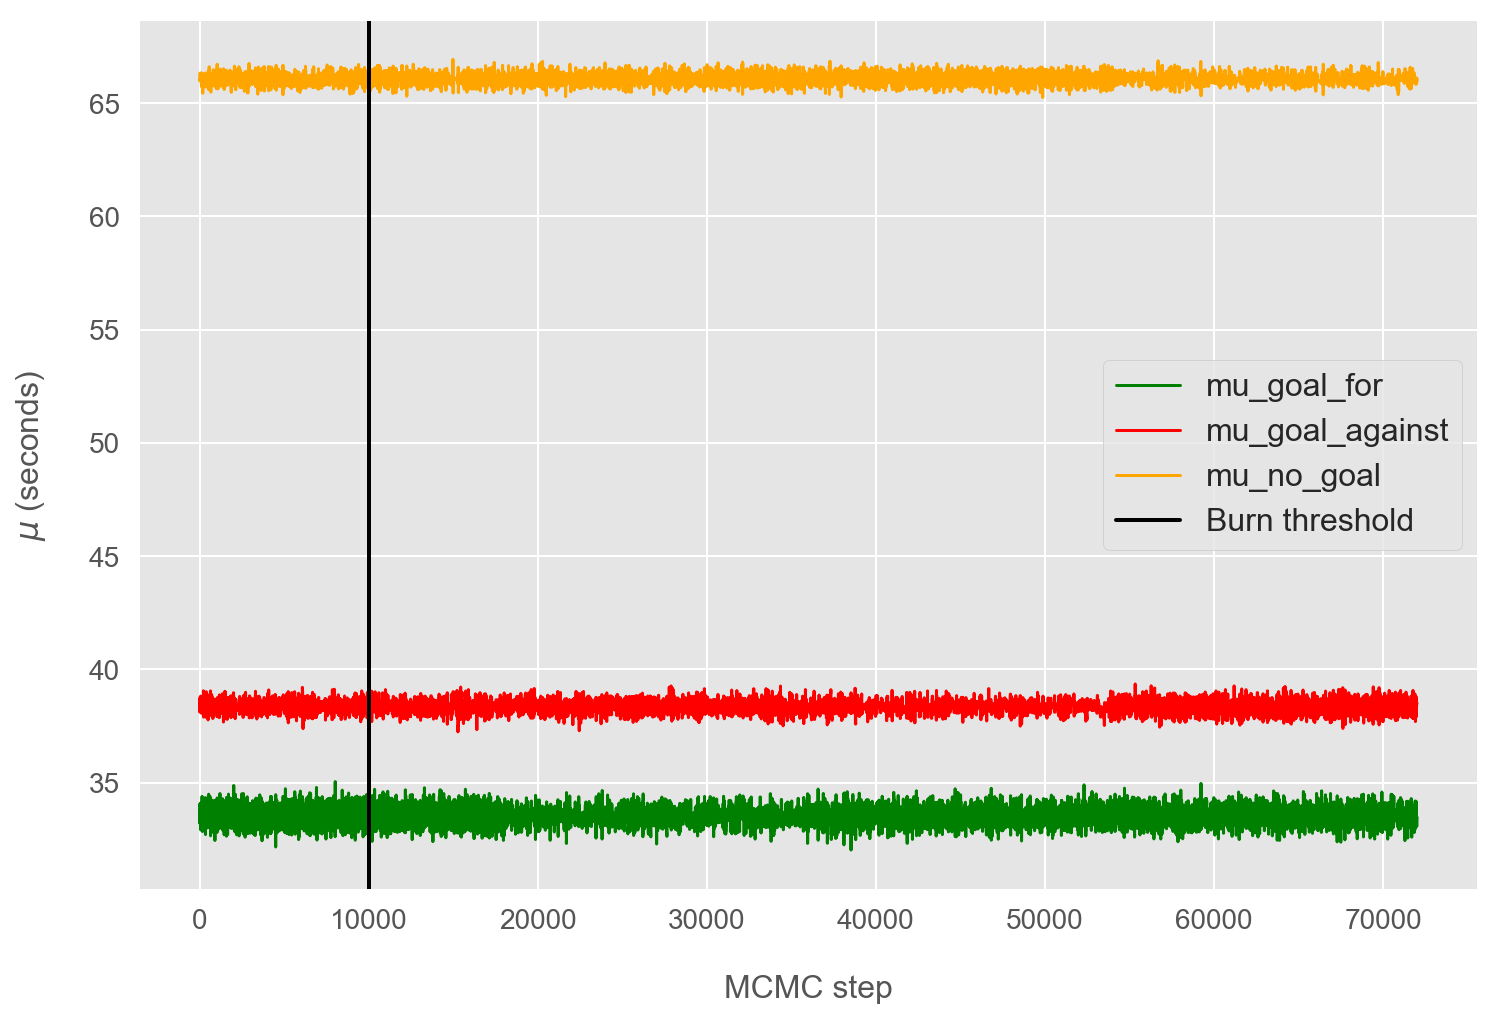

In [128]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.plot(trace['mu_no_goal'], label='mu_no_goal', color='orange')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend()

savefig(plt, 'time_since_mu_steps')

plt.show()

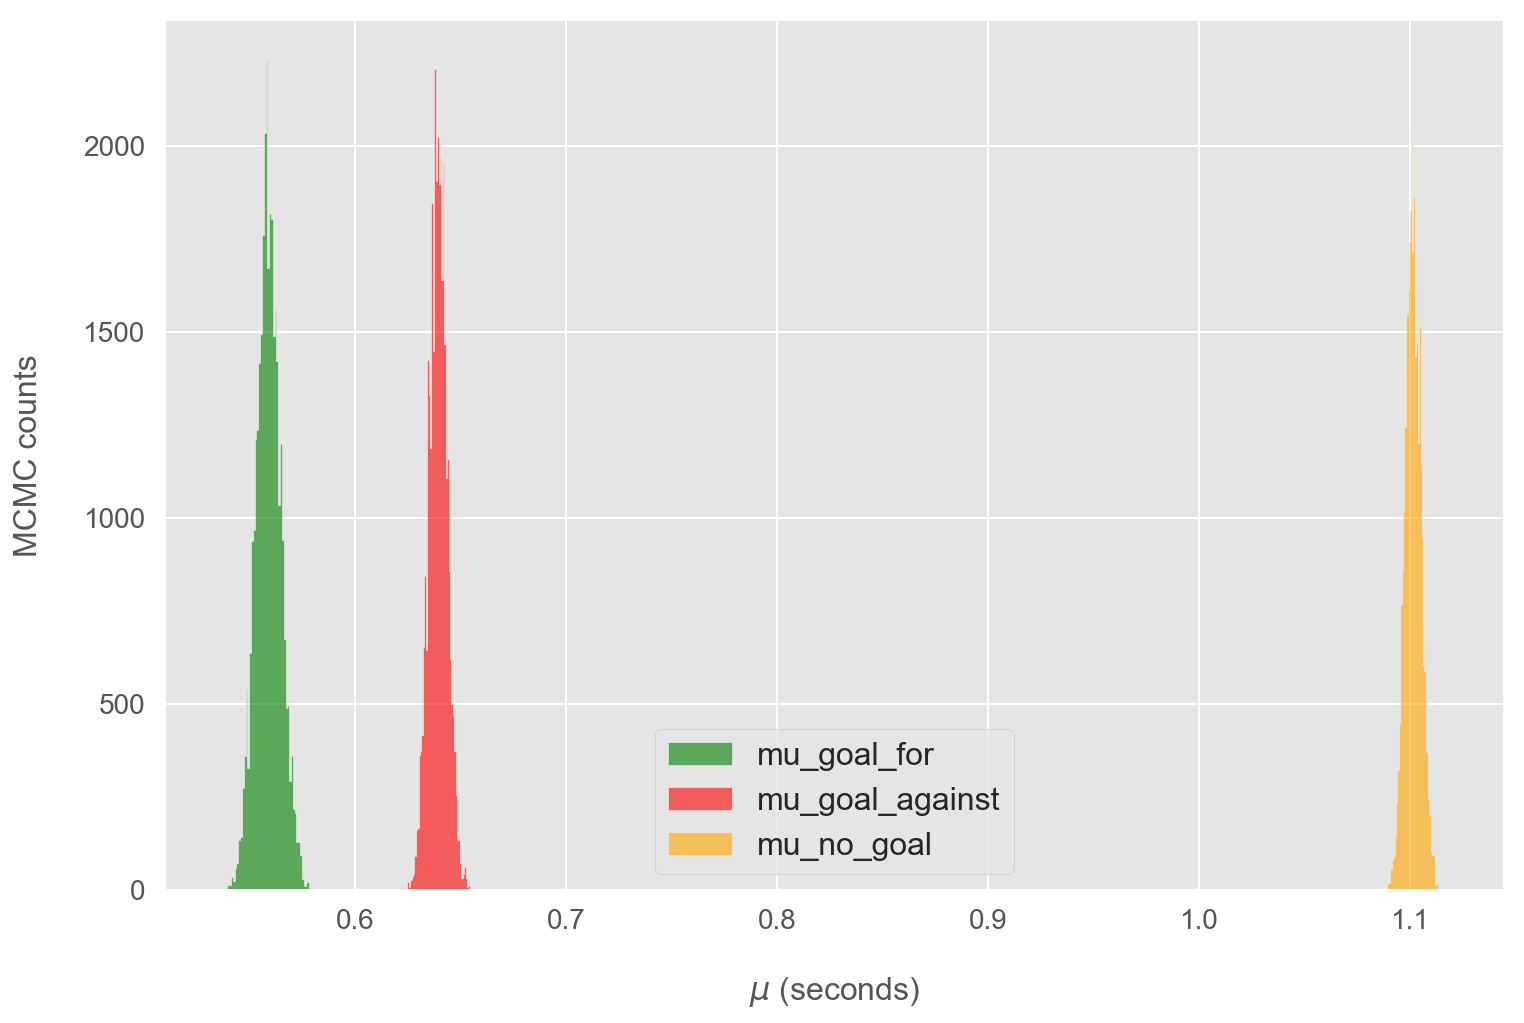

In [129]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for']/60, bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against']/60, bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_no_goal']/60, bins=50,
         color='orange', label='mu_no_goal',
         histtype='stepfilled', alpha=ALPHA)

plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend()

savefig(plt, 'time_elapsed_mu_samples')
plt.show()

### Normalization

Now I need to normalize these. Let's confirm equal sample numbers

In [130]:
(burned_trace['mu_goal_for'].shape,
burned_trace['mu_goal_against'].shape,
burned_trace['mu_no_goal'].shape)

((32000,), (32000,), (32000,))

In [131]:
len(burned_trace) * 4

32000

Nice! Same number of samlpes. Weird that it's 4x my burned trace amount - probably due to 4 cores

Let's define the average shape parameter $\mu$ and then solve for the normalizing fractions.

In [132]:
mu_mcmc = [
    burned_trace['mu_goal_for'].mean(),
    burned_trace['mu_goal_against'].mean(),
    burned_trace['mu_no_goal'].mean(),
]

print(f'MCMC values for mu: {mu_mcmc}')

MCMC values for mu: [33.52173106145377, 38.34939626049066, 66.07345983181534]


In [133]:
mcmc_normalizing_factors = np.array([
    training_samples[0].shape[0],
     training_samples[1].shape[0],
     training_samples[2].shape[0]
])
mcmc_normalizing_factors = mcmc_normalizing_factors / mcmc_normalizing_factors.sum()

print(f'MCMC normalizing factors =\n{mcmc_normalizing_factors}')

MCMC normalizing factors =
[0.1268201  0.26021606 0.61296383]


In [134]:
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(mu_mcmc)

y_goal_for = y_goal_for * mcmc_normalizing_factors[0]
y_goal_against = y_goal_against * mcmc_normalizing_factors[1]
y_no_goal = y_no_goal * mcmc_normalizing_factors[2]

cutoff_renormed_factor = 2 - (y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum())
model_normalizing_factors = mcmc_normalizing_factors * cutoff_renormed_factor

print(f'Poisson normalizing factors =\n{model_normalizing_factors}')

Poisson normalizing factors =
[0.1268201  0.26021606 0.61296383]


Here's what the properly weighted samlpes look like:

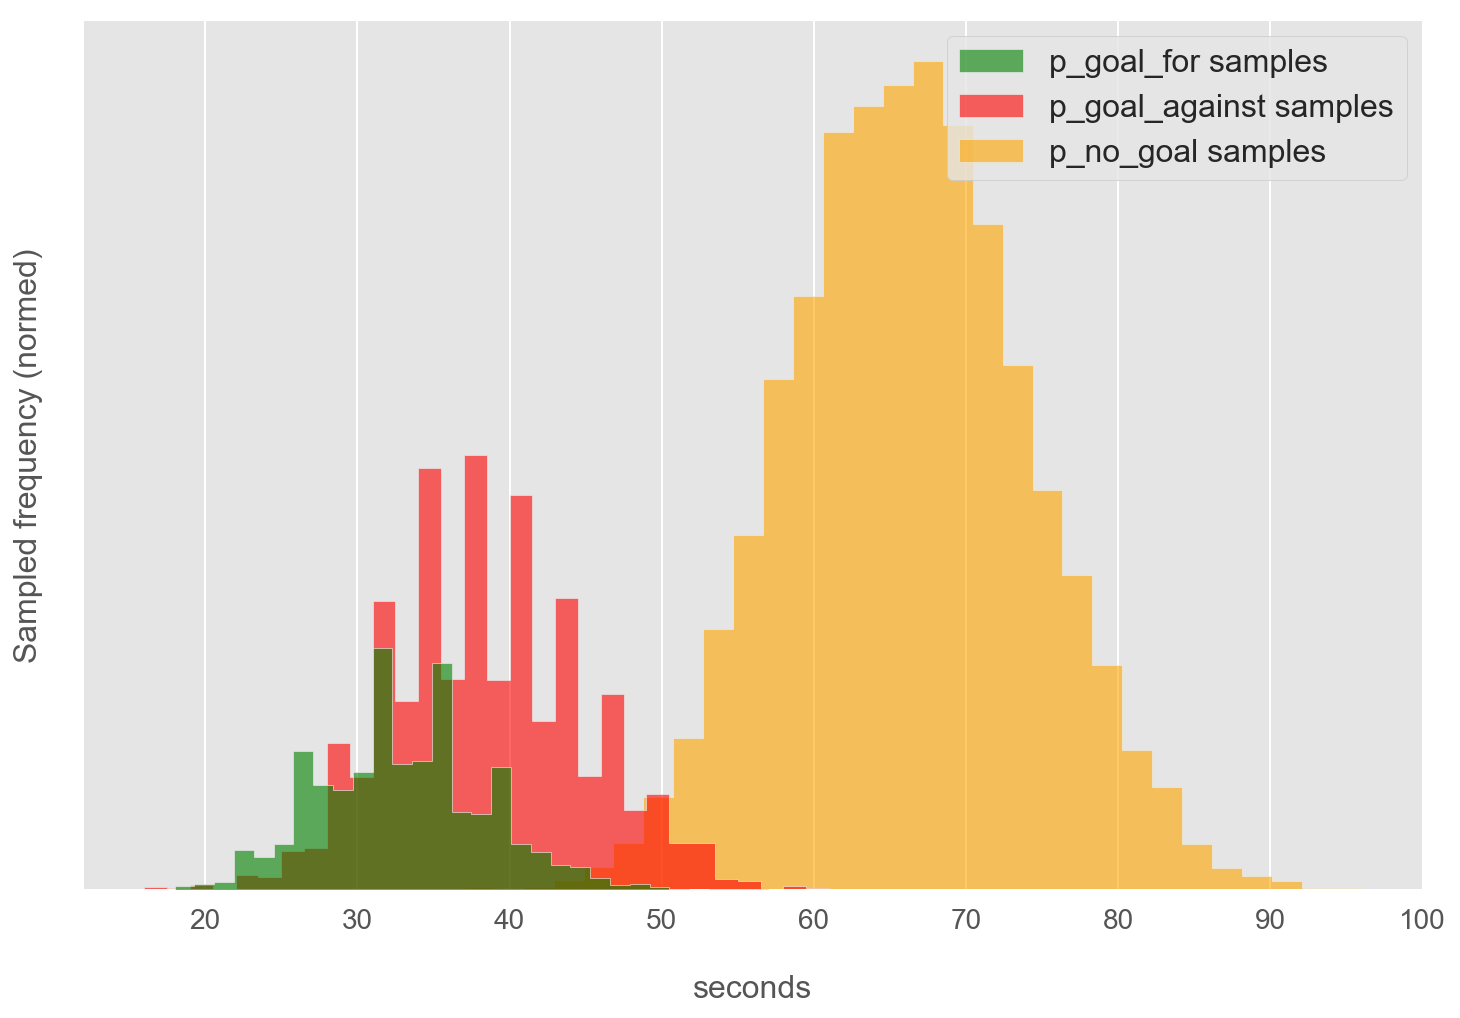

In [135]:
ALPHA = 0.6
LW = 3
BINS = 30

''' Plot the MCMC samples '''

plt.hist(np.random.choice(
            burned_trace['p_goal_for'],
            size=int(burned_trace['p_goal_for'].shape[0] * mcmc_normalizing_factors[0])
         ),
         bins=BINS, color='green', label='p_goal_for samples',
         histtype='stepfilled', alpha=ALPHA, zorder=3)

plt.hist(np.random.choice(
            burned_trace['p_goal_against'],
            size=int(burned_trace['p_goal_against'].shape[0] * mcmc_normalizing_factors[1])
         ),
         bins=BINS,
         color='red', label='p_goal_against samples',
         histtype='stepfilled', alpha=ALPHA, zorder=2)

plt.hist(np.random.choice(
            burned_trace['p_no_goal'],
            size=int(burned_trace['p_no_goal'].shape[0] * mcmc_normalizing_factors[2])
         ),
         bins=BINS,
         color='orange', label='p_no_goal samples',
         histtype='stepfilled', alpha=ALPHA)

plt.ylabel('Sampled frequency (normed)')
plt.yticks([])
plt.xlabel('seconds')
plt.legend();

savefig(plt, 'time_since_normed_poisson_mcmc_samples')

plt.show()

### Normalized Posteriors

Re-normalize for cutoff Poisson distributions

In [136]:
import inspect
print(inspect.getsource(poisson_posterior))

def poisson_posterior(
    mu=None,
    norm_factors=None,
) -> Tuple[np.ndarray]:

    p = poisson.pmf
    x = np.arange(0, 5*60, 1)
    if mu is None:
#         return (x / 60,)
        return (x,)
    
    mu_goal_for = mu[0]
    mu_goal_against = mu[1]
    mu_no_goal = mu[2]

    y_goal_for = p(x, mu_goal_for)
    y_goal_against = p(x, mu_goal_against)
    y_no_goal = p(x, mu_no_goal)
    
    if norm_factors is not None:
        y_goal_for = p(x, mu_goal_for) * norm_factors[0]
        y_goal_against = p(x, mu_goal_against) * norm_factors[1]
        y_no_goal = p(x, mu_no_goal) * norm_factors[2]
    
    # Convert into minutes
#     x = x / 60

    return x, y_goal_for, y_goal_against, y_no_goal



In [137]:
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)

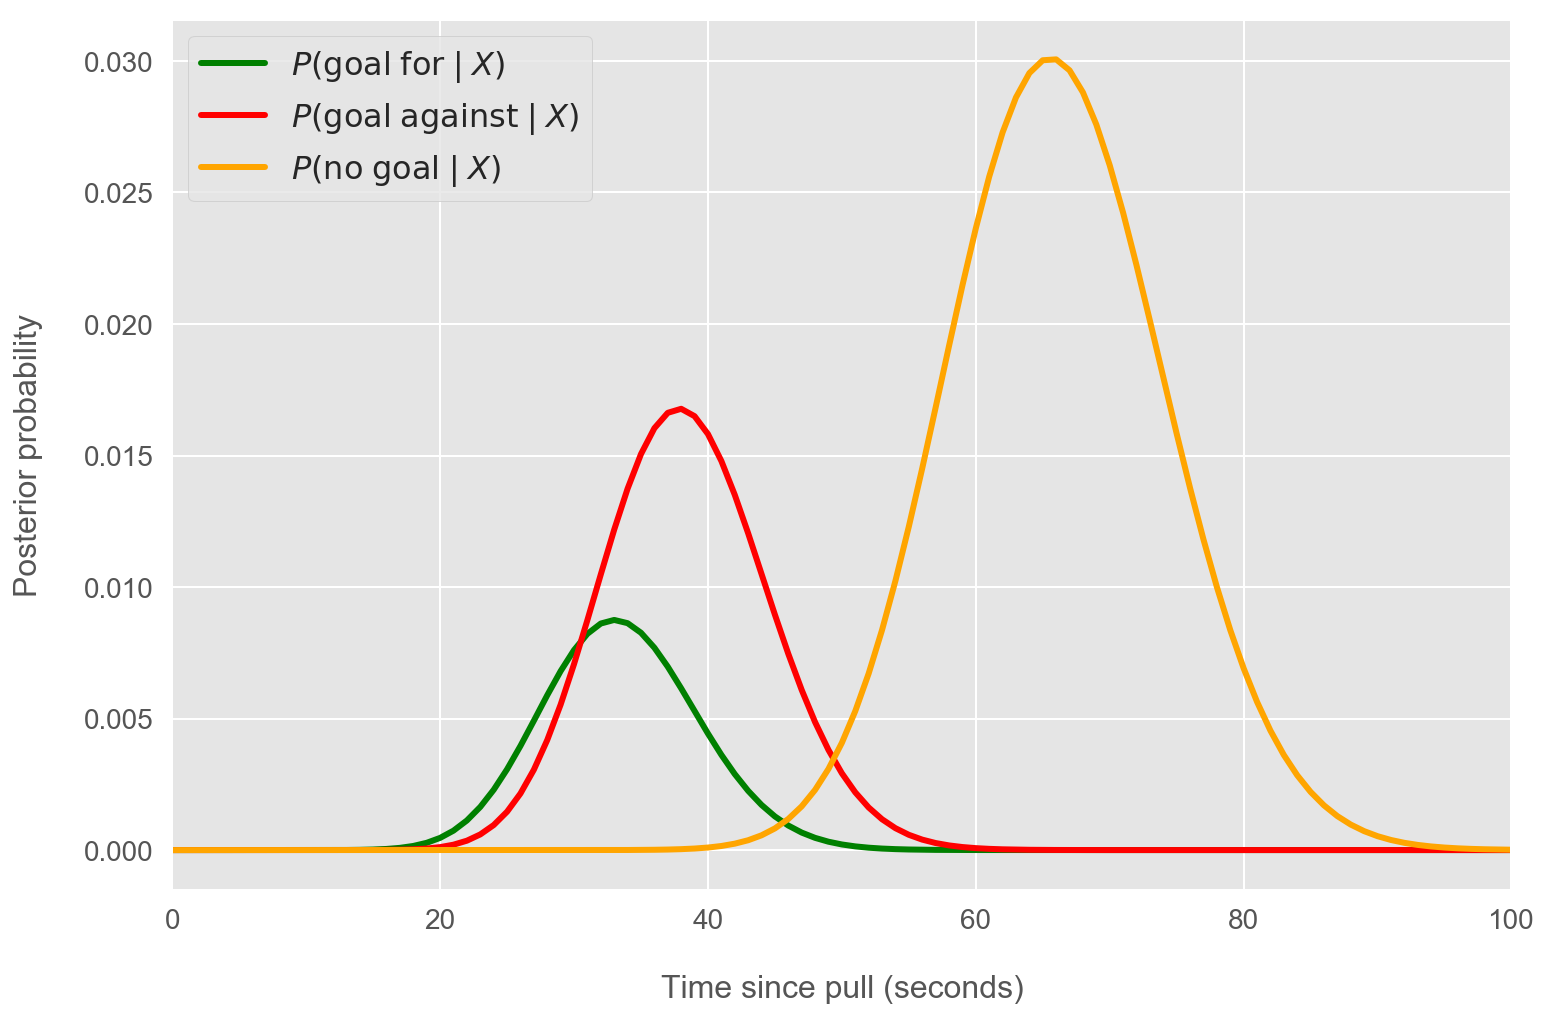

In [138]:
from scipy.stats import poisson
ALPHA = 0.6
LW = 3 

''' Plot the poisson distributions '''
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)
plt.plot(x, y_goal_for, label=r'$P(\mathrm{goal\;for}\;|\;X)$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\mathrm{goal\;against}\;|\;X)$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$P(\mathrm{no\;goal}\;|\;X)$', color='orange', lw=LW)

plt.ylabel('Posterior probability')
# plt.yticks([])
plt.xlabel('Time since pull (seconds)')
plt.legend()
plt.xlim(0, 100)

savefig(plt, 'time_since_normed_poisson')

plt.show()

### Interpretation

In [139]:
print('Time of max posterior probability =\n'
      f'{x[np.argmax(y_goal_for)], x[np.argmax(y_goal_against)], x[np.argmax(y_no_goal)]}')

Time of max posterior probability =
(33, 38, 66)


Notes:
 - Goals usually come 30 seconds - 1 minutes after pulling the goalie.
 - Games tend to end 1 minute - 1 min 30 seconds after pulling the goalie. This roughly corresponds to the average time remaining on pull.
 
From now on we'll work from the distributions as our source of truth. These are hard coded below to help with reproducibility.

In [140]:
model_normlizing_factors = [
    0.1268201,
    0.26021606,
    0.61296383
]

mu_mcmc = [
    33.53749551104675,
    38.35247984655338,
    66.0835441233016
]

### Cumulative sum

Calculating the CDF will allow us to make some interesting observations on the results.

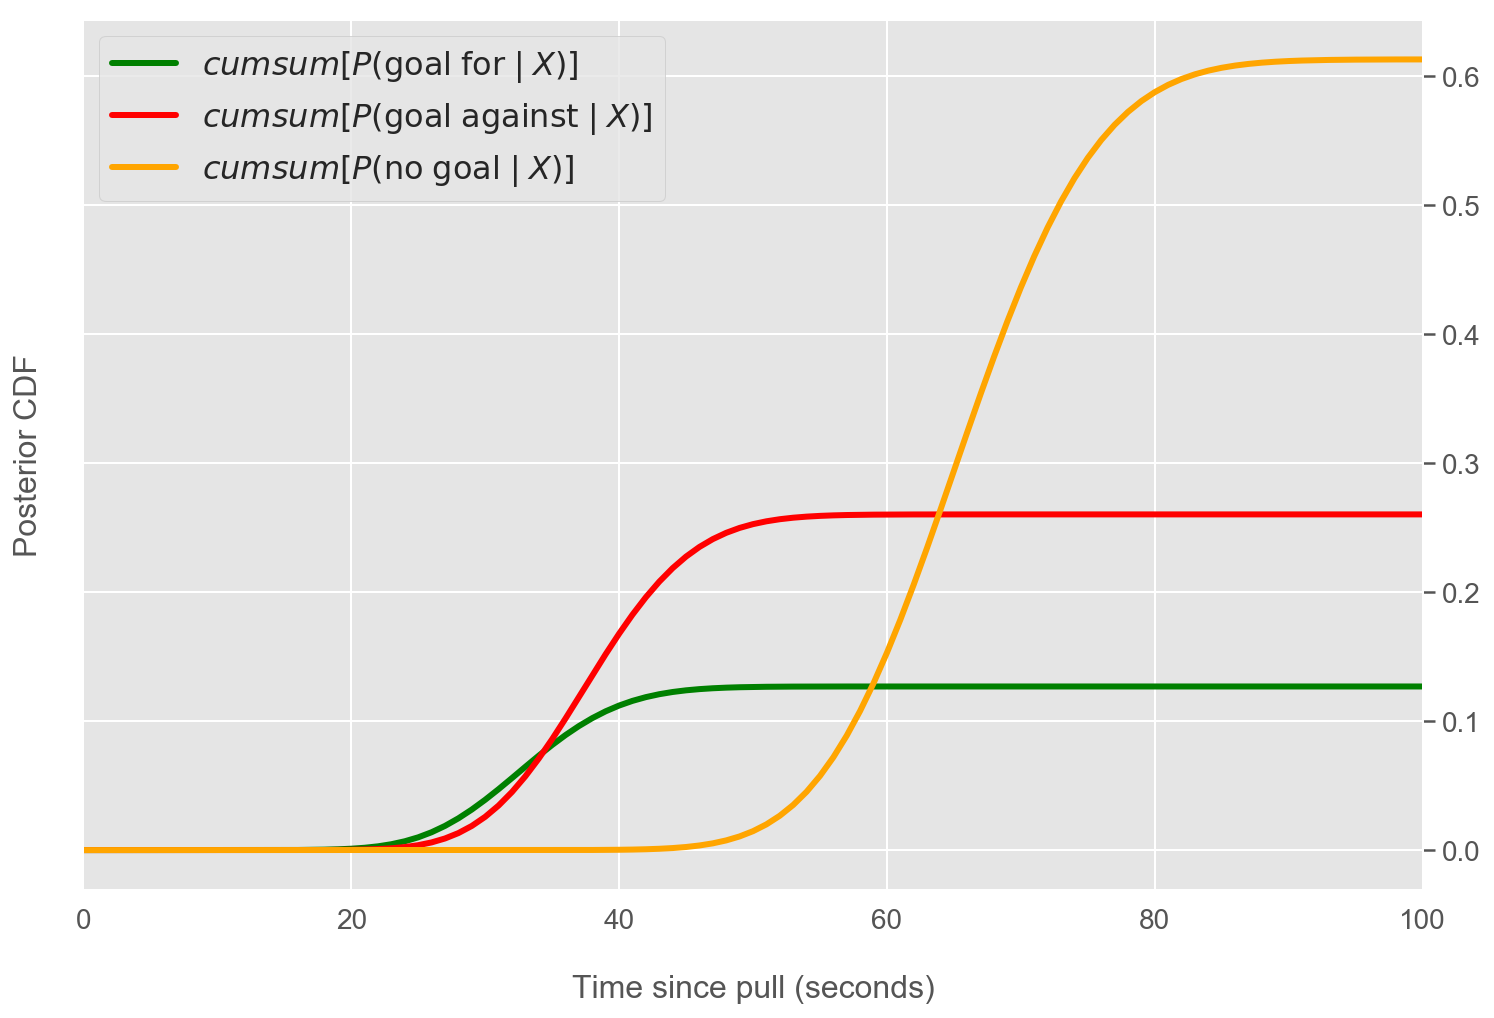

In [141]:
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)

plt.plot(x, np.cumsum(y_goal_for), label=r'$cumsum [ P(\mathrm{goal\;for}\;|\;X) ]$', color='green', lw=LW)
plt.plot(x, np.cumsum(y_goal_against), label=r'$cumsum [ P(\mathrm{goal\;against}\;|\;X) ]$', color='red', lw=LW)
plt.plot(x, np.cumsum(y_no_goal), label=r'$cumsum [ P(\mathrm{no\;goal}\;|\;X) ]$', color='orange', lw=LW)

plt.ylabel('Posterior CDF')
# plt.yticks([])
plt.xlabel('Time since pull (seconds)')
plt.legend()

ax = plt.gca()
ax.yaxis.tick_right()
plt.xlim(0, 100)

savefig(plt, 'time_since_poisson_cdf')

plt.show()

The end of game values have been normalized sum up to one, but this ratio changes over time. We can visualize this with the risk-reward ratio (see below).

### Re-normalize

To better compare these probability distributions, we can normalize each bin to 1 using a function $\alpha(t)$, as follows:

$$
\alpha(t) \cdot \big[ P(goal\;for; t) + (P(goal\;against; t) + P(no\;goal; t)\big] = 1 \\
\vdots \\
\alpha(t) = \big[ P(goal\;for; t) + (P(goal\;against; t) + P(no\;goal; t)\big]^{-1}
$$

This will allow us to re-weight the posteriors later, so we can compare them better and yield a different interpretation.

Essentially, we'll be able to interpret the resulting distribution as the chance of each outcome at time $t$. This stands in contrast to the probability distributions above, where the total area under the curves sum to 1.

In [142]:
alpha = np.power(
    np.sum([y_goal_for, y_goal_against, y_no_goal], axis=0),
    -1
)

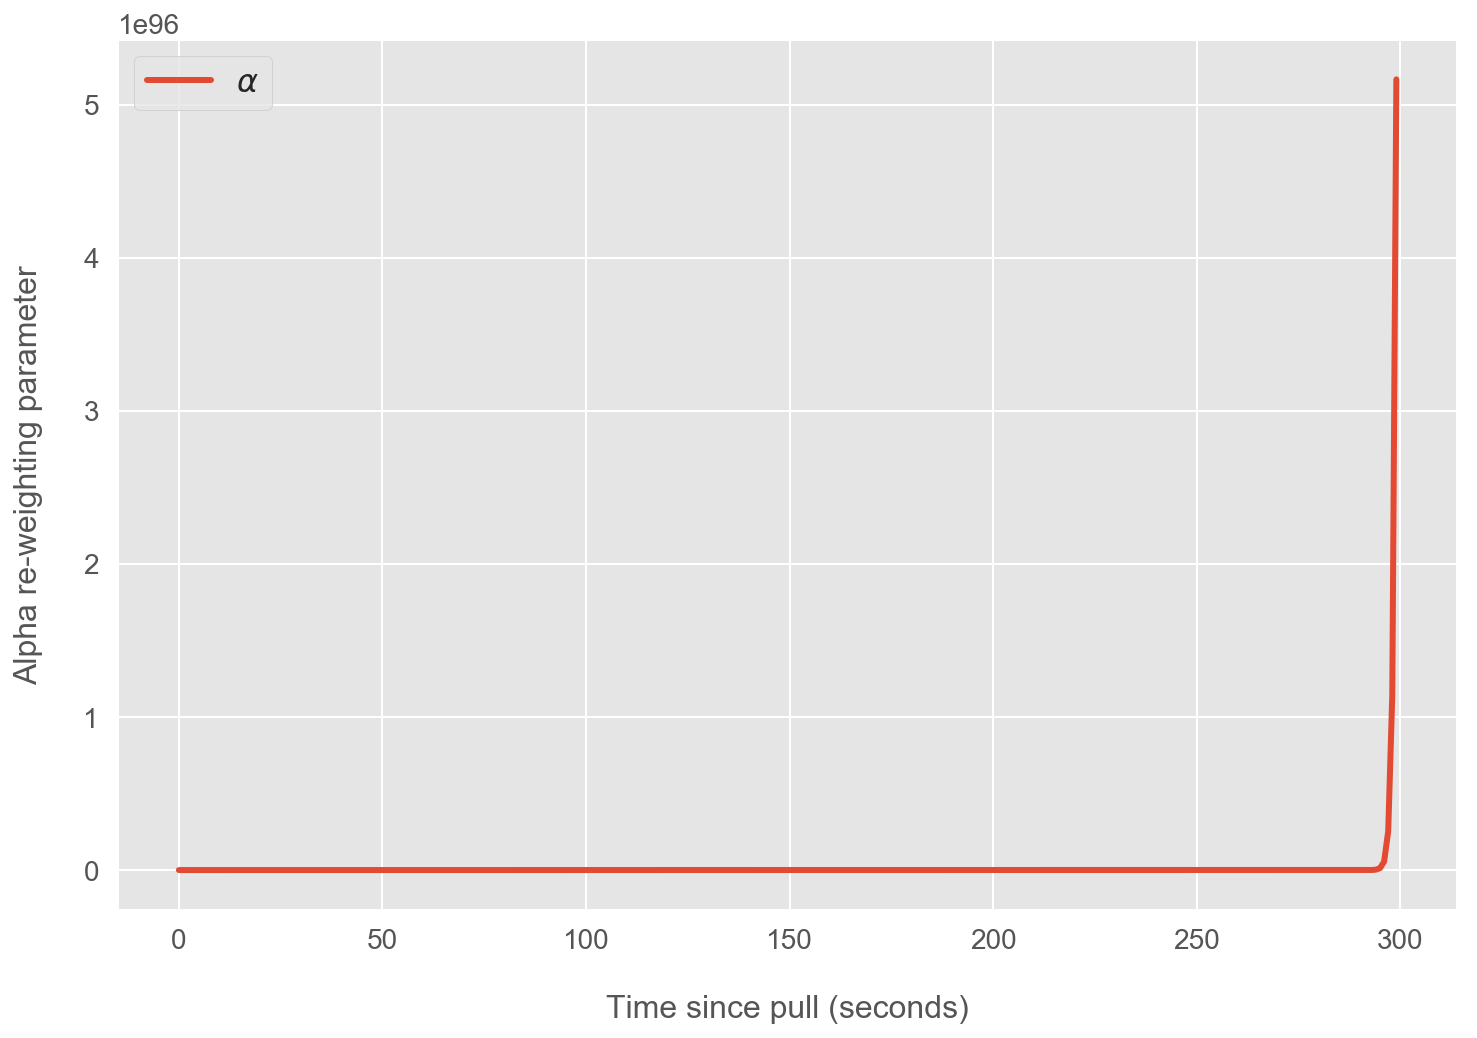

In [143]:
plt.plot(x, alpha, label=r'$\alpha$', lw=LW)
plt.ylabel('Alpha re-weighting parameter')
# plt.yticks([])
plt.xlabel('Time since pull (seconds)')
plt.legend()

# savefig(plt, 'time_elapsed_poisson_cdf')

plt.show()

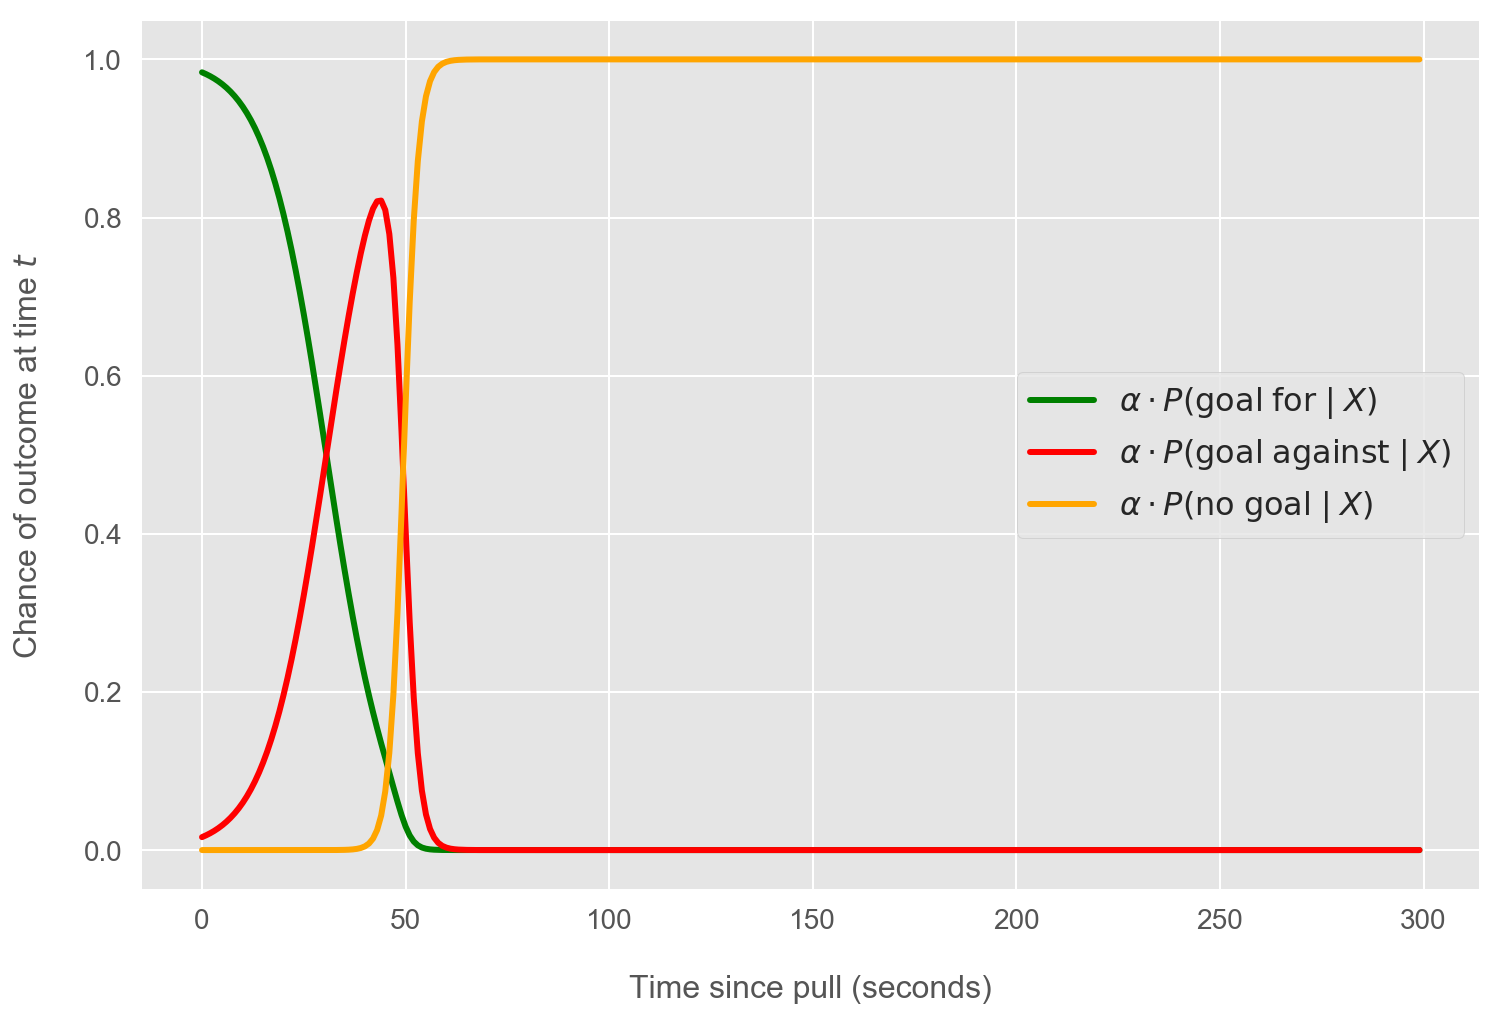

In [144]:
from scipy.stats import poisson
ALPHA = 0.6
LW = 3 

''' Plot the poisson distributions '''
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)

# Alpha has same shape as x, y above
alpha = np.power(
    np.sum([y_goal_for, y_goal_against, y_no_goal], axis=0),
    -1
)

y_goal_for = alpha * y_goal_for
y_goal_against = alpha * y_goal_against
y_no_goal = alpha * y_no_goal
plt.plot(x, y_goal_for, label=r'$\alpha \cdot P(\mathrm{goal\;for}\;|\;X)$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$\alpha \cdot P(\mathrm{goal\;against}\;|\;X)$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$\alpha \cdot P(\mathrm{no\;goal}\;|\;X)$', color='orange', lw=LW)

plt.ylabel('Chance of outcome at time $t$')
# plt.yticks([])
plt.xlabel('Time since pull (seconds)')
plt.legend()

# Plotting below with error bar
# savefig(plt, 'time_since_outcome_chance_timeseries')

plt.show()

### Adding error bars

Note how there are very few samples to draw conclusions from for the low and high times.

e.g. more than 2 minutes

In [145]:
np.sum(training_samples[0] > 2*60) + np.sum(training_samples[1] > 2*60) + np.sum(training_samples[2] > 2*60)


114

In [146]:
np.sum(training_samples[0] < 2*60) + np.sum(training_samples[1] < 2*60) + np.sum(training_samples[2] < 2*60)


2015

We can show this uncertainty visually using error bars. Starting with the $\mu$ MCMC samples...

(array([  38.,  448., 2120., 6048., 8942., 7575., 4798., 1690.,  318.,
          23.]),
 array([65.25688583, 65.42485848, 65.59283113, 65.76080378, 65.92877643,
        66.09674909, 66.26472174, 66.43269439, 66.60066704, 66.76863969,
        66.93661234]),
 <a list of 10 Patch objects>)

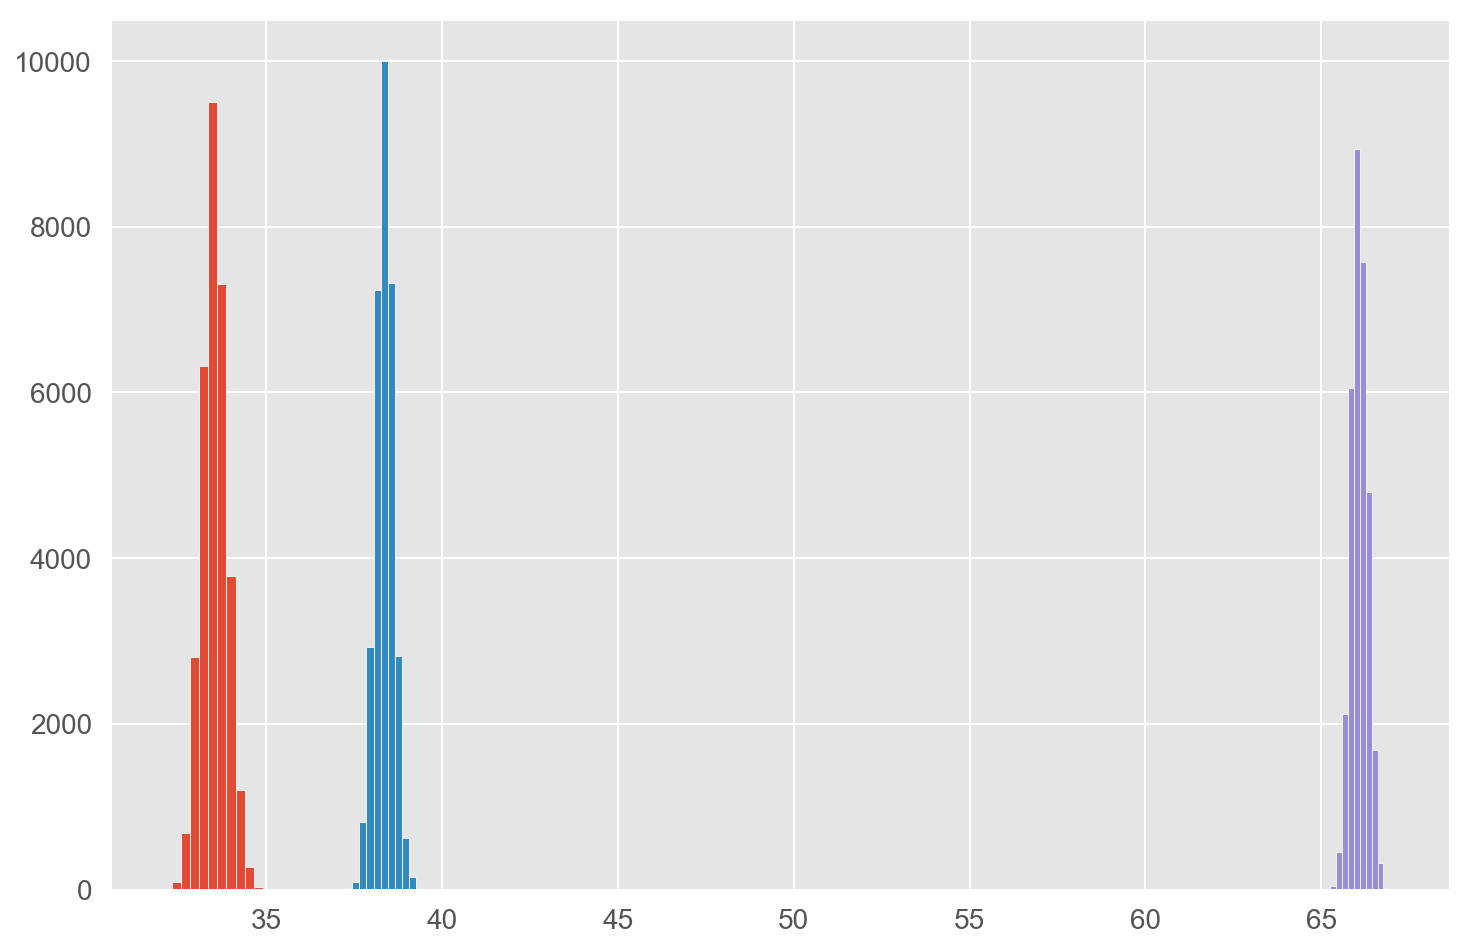

In [147]:
plt.hist(burned_trace['mu_goal_for'])
plt.hist(burned_trace['mu_goal_against'])
plt.hist(burned_trace['mu_no_goal'])

We can use the uncertainty on $\mu$ to calculate that for $P$:

$$
\sigma_P = \big| \frac{\partial P}{\partial \mu} \big|\;\sigma_{\mu}
$$

where $\sigma_{\mu}$ is the standard deviation of the $\mu$ samples.

In [148]:
mu_mcmc_std = [
    burned_trace['mu_goal_for'].std(),
    burned_trace['mu_goal_against'].std(),
    burned_trace['mu_no_goal'].std(),
]

In [149]:
mu_mcmc_std

[0.35280416421519667, 0.2600483116595569, 0.2285577958189885]

In [150]:
model_normalizing_factors

array([0.1268201 , 0.26021606, 0.61296383])

In [151]:
import inspect
print(inspect.getsource(poisson_posterior))

def poisson_posterior(
    mu=None,
    norm_factors=None,
) -> Tuple[np.ndarray]:

    p = poisson.pmf
    x = np.arange(0, 5*60, 1)
    if mu is None:
#         return (x / 60,)
        return (x,)
    
    mu_goal_for = mu[0]
    mu_goal_against = mu[1]
    mu_no_goal = mu[2]

    y_goal_for = p(x, mu_goal_for)
    y_goal_against = p(x, mu_goal_against)
    y_no_goal = p(x, mu_no_goal)
    
    if norm_factors is not None:
        y_goal_for = p(x, mu_goal_for) * norm_factors[0]
        y_goal_against = p(x, mu_goal_against) * norm_factors[1]
        y_no_goal = p(x, mu_no_goal) * norm_factors[2]
    
    # Convert into minutes
#     x = x / 60

    return x, y_goal_for, y_goal_against, y_no_goal



In [152]:
from scipy.misc import derivative
from tqdm import tqdm_notebook

def calc_posteror_error(mu, mu_std, mu_step=1e-6):
    x = poisson_posterior()[0]
    err = mu_std * np.abs(np.array([
        derivative(lambda _mu: poisson.pmf(int(t), _mu), mu, dx=mu_step)
        for t in tqdm_notebook(x)
    ]))
    return err

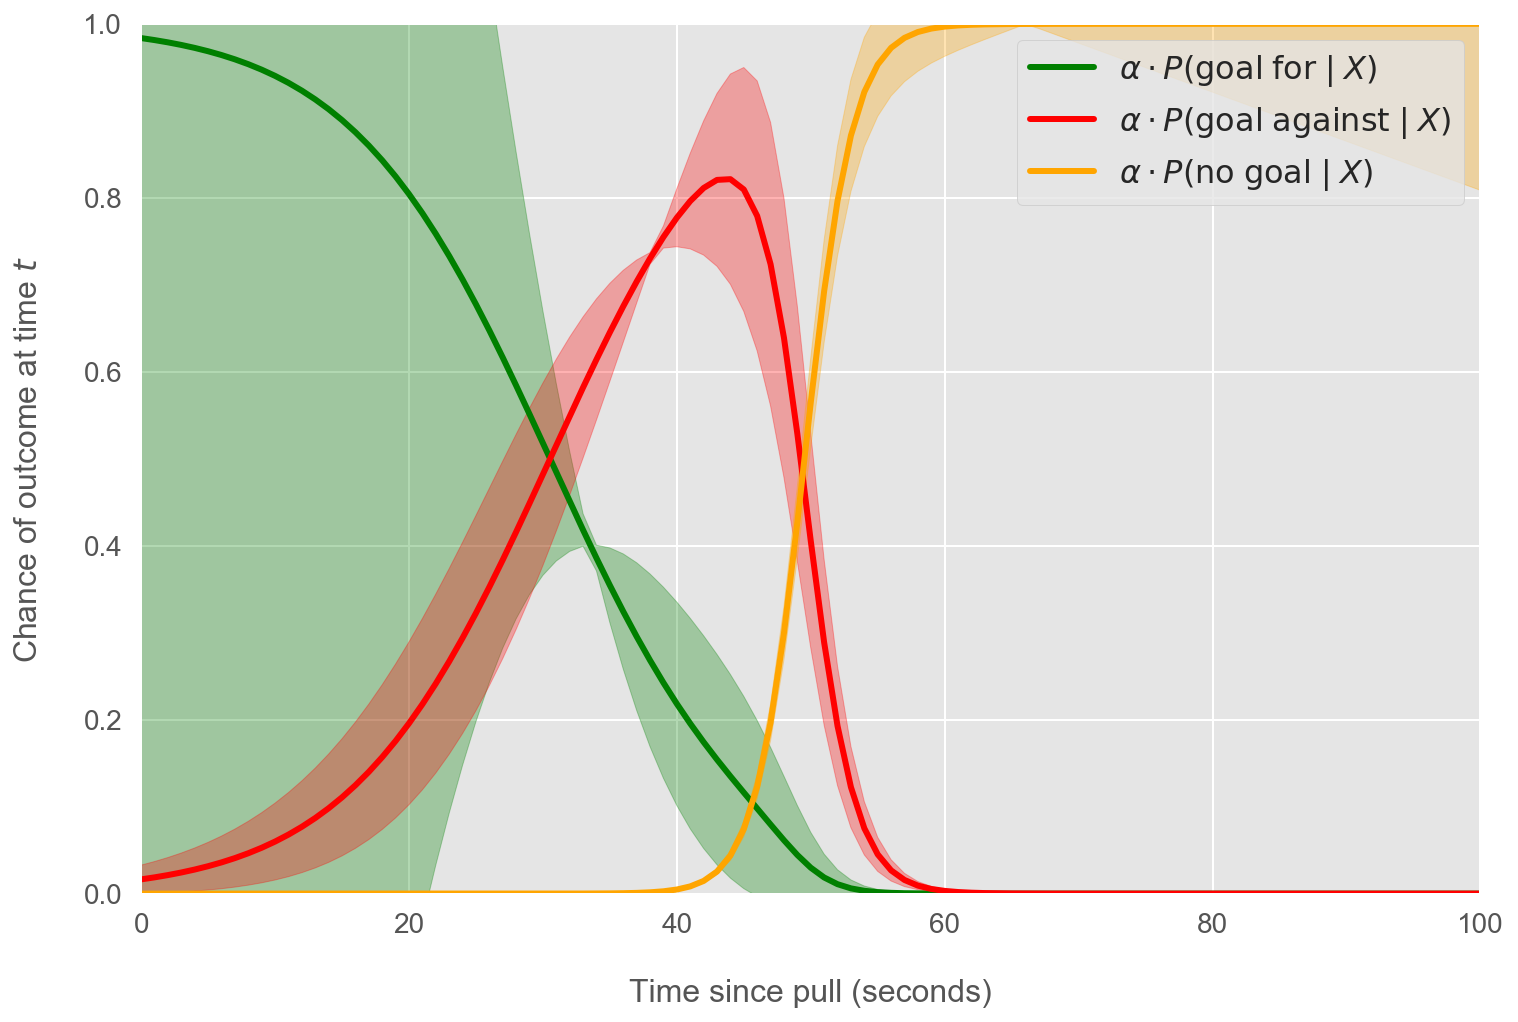

In [153]:
from scipy.stats import poisson
ALPHA = 0.6
ALPHA_LIGHT = 0.3
LW = 3

''' Plot the poisson distributions '''
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)

# Alpha has same shape as x, y above
alpha = np.power(
    np.sum([y_goal_for, y_goal_against, y_no_goal], axis=0),
    -1
)

y_goal_for = alpha * y_goal_for
y_goal_against = alpha * y_goal_against
y_no_goal = alpha * y_no_goal
plt.plot(x, y_goal_for, label=r'$\alpha \cdot P(\mathrm{goal\;for}\;|\;X)$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$\alpha \cdot P(\mathrm{goal\;against}\;|\;X)$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$\alpha \cdot P(\mathrm{no\;goal}\;|\;X)$', color='orange', lw=LW)

''' Plot the errors '''
err_p_goal_for = alpha * calc_posteror_error(mu_mcmc[0], mu_mcmc_std[0])
err_p_goal_against = alpha * calc_posteror_error(mu_mcmc[1], mu_mcmc_std[1])
err_p_no_goal = alpha * calc_posteror_error(mu_mcmc[2], mu_mcmc_std[2])
plt.fill_between(x, y_goal_for-err_p_goal_for, y_goal_for+err_p_goal_for,
                 color='green', alpha=ALPHA_LIGHT)
plt.fill_between(x, y_goal_against-err_p_goal_against, y_goal_against+err_p_goal_against,
                 color='red', alpha=ALPHA_LIGHT)
plt.fill_between(x, y_no_goal-err_p_no_goal, y_no_goal+err_p_no_goal,
                 color='orange', alpha=ALPHA_LIGHT)

plt.ylabel('Chance of outcome at time $t$')
# plt.yticks([])
plt.xlabel('Time since pull (seconds)')
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.legend()

savefig(plt, 'time_since_outcome_chance_timeseries')

plt.show()

We can't say anything conclusive due to huge errors on low times, but we are much more confident on late game predictions

### Odds of scoring a goal
Let's go into odds-space and look at the chance of scoring a goal, compared to either outcome. We want to maximze this.

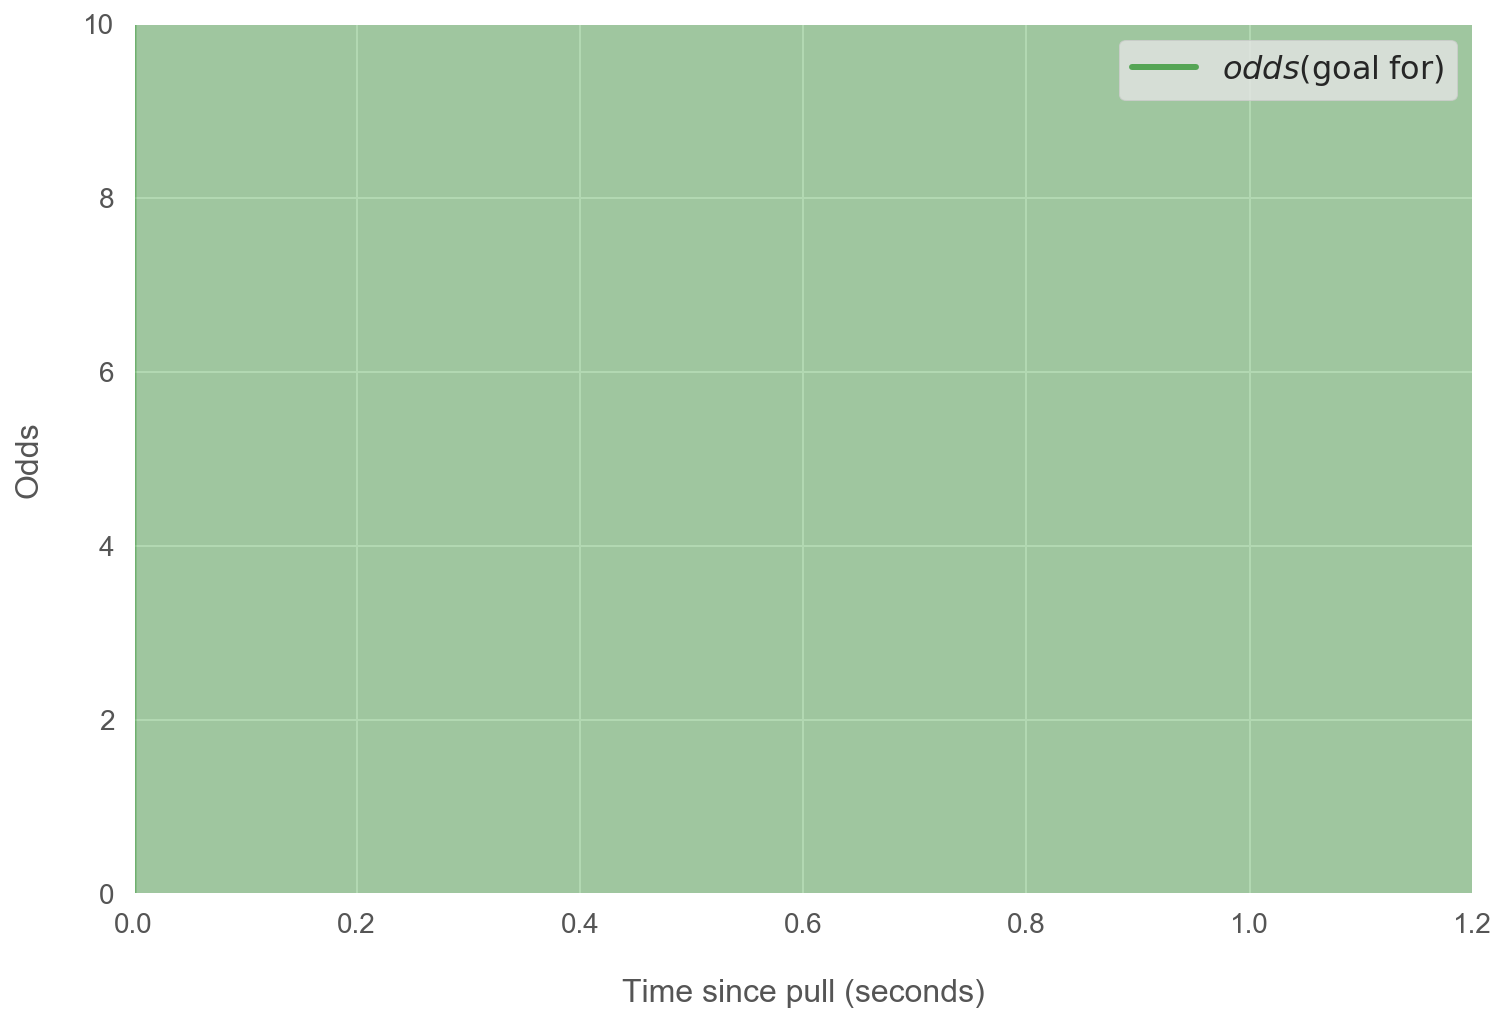

In [154]:
ALPHA = 0.6
ALPHA_LIGHT = 0.3
LW = 3

''' Odds ratio '''

x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)

odds_goal_for = y_goal_for / (y_goal_against + y_no_goal)

''' Error bars '''

err_p_goal_for = calc_posteror_error(mu_mcmc[0], mu_mcmc_std[0])
err_p_goal_against = calc_posteror_error(mu_mcmc[1], mu_mcmc_std[1])
err_p_no_goal = calc_posteror_error(mu_mcmc[2], mu_mcmc_std[2])
err_odds_goal_for = (
    np.power(err_p_goal_for / y_goal_for, 2)
    + np.power(err_p_goal_against / y_goal_against, 2)
    + np.power(err_p_no_goal / y_no_goal, 2)
)
err_odds_goal_for = odds_goal_for * np.sqrt(err_odds_goal_for)

''' Plots '''

plt.plot(x, odds_goal_for,
         label=r'$odds(\mathrm{goal\;for})$',
         color='green', lw=LW, alpha=ALPHA)
plt.fill_between(x, odds_goal_for-err_odds_goal_for, odds_goal_for+err_odds_goal_for,
                 color='green', lw=LW, alpha=ALPHA_LIGHT)

plt.ylabel('Odds')
# plt.yticks([])
plt.xlabel('Time since pull (seconds)')

plt.xlim(0, 1.2)
plt.ylim(0, 10)

plt.legend()

# savefig(plt, 'time_since_odds_goal_for')

plt.show()

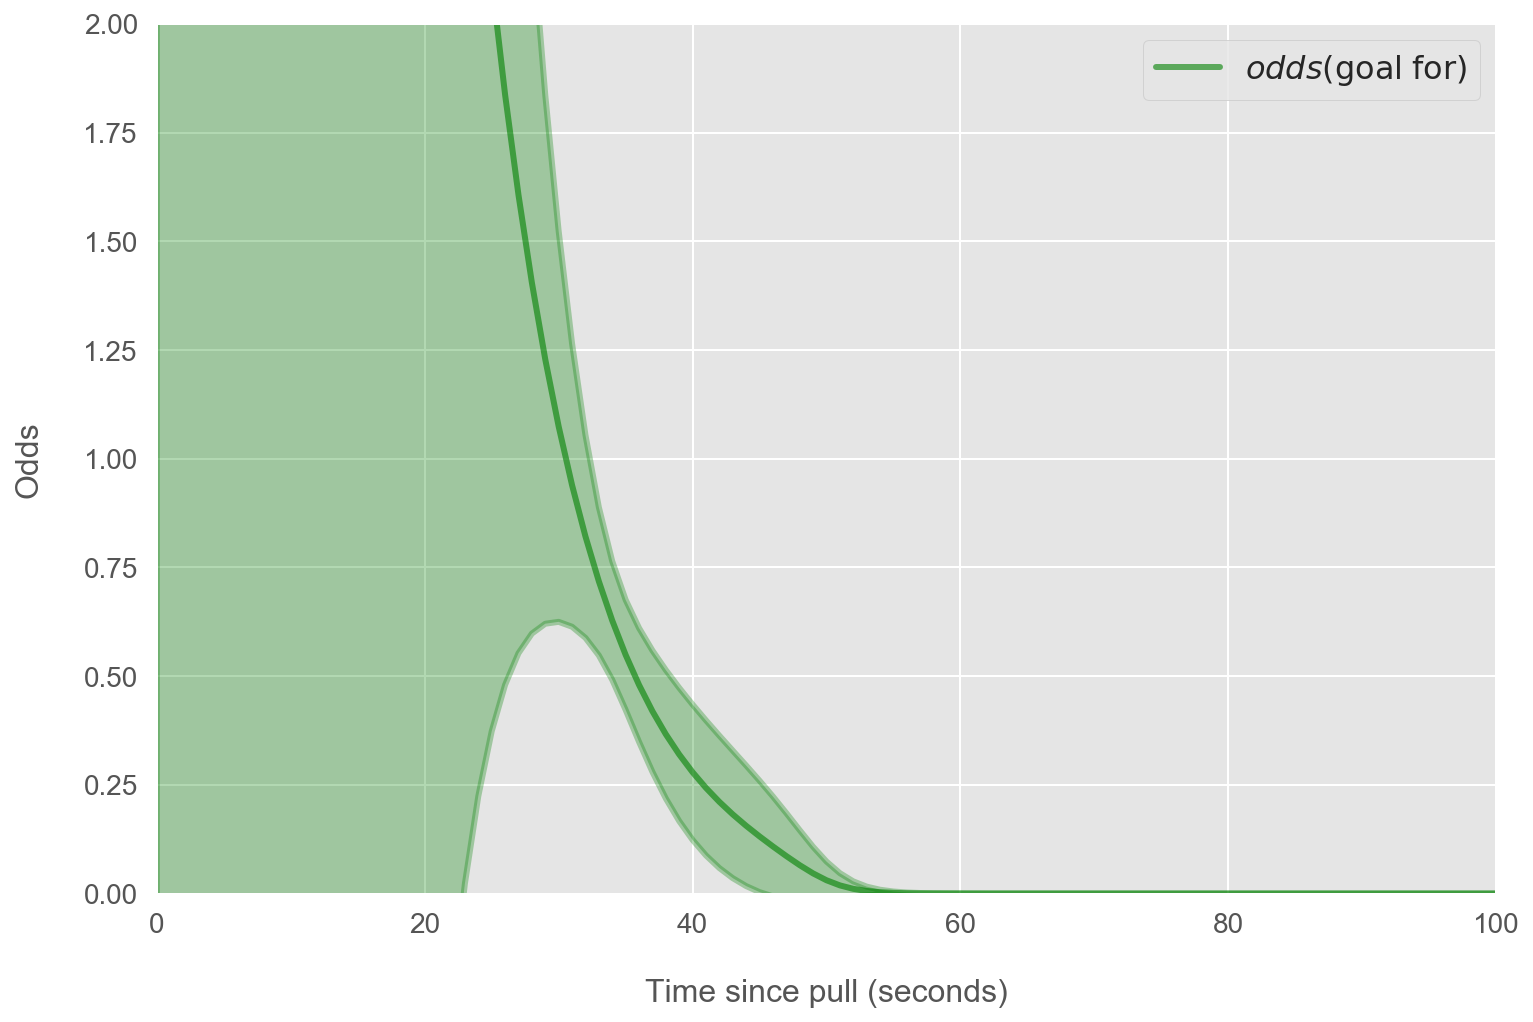

In [155]:
ALPHA = 0.6
ALPHA_LIGHT = 0.3
LW = 3

''' Odds ratio '''

x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(
    mu_mcmc, norm_factors=model_normalizing_factors
)

odds_goal_for = y_goal_for / (y_goal_against + y_no_goal)

''' Error bars '''

err_p_goal_for = calc_posteror_error(mu_mcmc[0], mu_mcmc_std[0])
err_p_goal_against = calc_posteror_error(mu_mcmc[1], mu_mcmc_std[1])
err_p_no_goal = calc_posteror_error(mu_mcmc[2], mu_mcmc_std[2])
err_odds_goal_for = (
    np.power(err_p_goal_for / y_goal_for, 2)
    + np.power(err_p_goal_against / y_goal_against, 2)
    + np.power(err_p_no_goal / y_no_goal, 2)
)
err_odds_goal_for = odds_goal_for * np.sqrt(err_odds_goal_for)

''' Plots '''

plt.plot(x, odds_goal_for,
         label=r'$odds(\mathrm{goal\;for})$',
         color='green', lw=LW, alpha=ALPHA)
plt.fill_between(x, odds_goal_for-err_odds_goal_for, odds_goal_for+err_odds_goal_for,
                 color='green', lw=LW, alpha=ALPHA_LIGHT)

plt.ylabel('Odds')
# plt.yticks([])
plt.xlabel('Time since pull (seconds)')

plt.xlim(0, 100)
plt.ylim(0, 2)

plt.legend()

savefig(plt, 'time_since_odds_goal_for')

plt.show()

In [156]:
(odds_goal_for-err_odds_goal_for).max()

0.624918282271564

This chart suggests that odds of scoring drop off the longer the goalie remains pulled. There's no statistically significant evidence for odds at less than 30 seconds, after which the odds drop from ~0.6 to 0 within the first minute.

In [55]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')